<a href="https://colab.research.google.com/github/Kat290/2025-spring-B2/blob/main/Milestone_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Milestone Two: Modeling and Feature Engineering

### Due: Midnight on August 3 (with 2-hour grace period) and worth 50 points

### Overview

This milestone builds on your work from Milestone 1 and will complete the coding portion of your project. You will:

1. Pick 3 modeling algorithms from those we have studied.
2. Evaluate baseline models using default settings.
3. Engineer new features and re-evaluate models.
4. Use feature selection techniques and re-evaluate.
5. Fine-tune for optimal performance.
6. Select your best model and report on your results.

You must do all work in this notebook and upload to your team leader's account in Gradescope. There is no
Individual Assessment for this Milestone.


In [ ]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



### Prelude: Load your Preprocessed Dataset from Milestone 1

In Milestone 1, you handled missing values, encoded categorical features, and explored your data. Before you begin this milestone, you’ll need to load that cleaned dataset and prepare it for modeling. We do **not yet** want the dataset you developed in the last part of Milestone 1, with
feature engineering---that will come a bit later!

Here’s what to do:

1. Return to your Milestone 1 notebook and rerun your code through Part 3, where your dataset was fully cleaned (assume it’s called `df_cleaned`).

2. **Save** the cleaned dataset to a file by running:

>   df_cleaned.to_csv("zillow_cleaned.csv", index=False)

3. Switch to this notebook and **load** the saved data:

>   df = pd.read_csv("zillow_cleaned.csv")

4. Create a **train/test split** using `train_test_split`.  
   
6. **Standardize** the features (but not the target!) using **only the training data.** This ensures consistency across models without introducing data leakage from the test set:

>   scaler = StandardScaler()   
>   X_train_scaled = scaler.fit_transform(X_train)    
  
**Notes:**

- You will have to redo the scaling step if you introduce new features (which have to be scaled as well).


In [ ]:
# Import the cleaned data

df = pd.read_csv("zillow_cleaned.csv")
df = df.dropna()

In [ ]:
# Test/ Train Split
X = df.drop(columns=["taxvaluedollarcnt"])
y = df["taxvaluedollarcnt"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [ ]:
X_train.describe()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,...,poolcnt,propertylandusetypeid,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,assessmentyear,taxdelinquencyflag
count,34437.000000,34437.000000,34437.000000,34437.000000,34437.000000,34437.000000,34437.000000,34437.000000,34437.000000,34437.000000,...,34437.000000,34437.000000,34437.000000,34437.000000,34437.000000,34437.000000,34437.000000,34437.000000,34437.0,34437.000000
mean,2.193164,2.995325,6.434649,2.201952,1653.934375,1625.352377,0.119058,2.139866,0.582571,107.903882,...,0.190667,261.880477,34504.944209,2537.151087,96557.567420,1.486105,1.070389,1967.961471,2016.0,0.040160
std,0.846706,1.087290,1.431786,0.835283,722.249728,687.469074,0.373654,0.829378,0.883938,209.172579,...,0.392833,4.903968,49701.744307,800.404130,1684.931975,2.806094,0.486470,23.443486,0.0,0.196338
min,0.000000,0.000000,1.000000,1.000000,242.000000,242.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,31.000000,3491.000000,1286.000000,95982.000000,0.000000,1.000000,1866.000000,2016.0,0.000000
25%,2.000000,2.000000,6.000000,2.000000,1156.000000,1153.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,261.000000,12447.000000,1286.000000,96206.000000,0.000000,1.000000,1953.000000,2016.0,0.000000
50%,2.000000,3.000000,6.000000,2.000000,1486.000000,1468.800000,0.000000,2.000000,0.000000,0.000000,...,0.000000,261.000000,25218.000000,3101.000000,96398.000000,0.000000,1.000000,1969.000000,2016.0,0.000000
75%,3.000000,4.000000,8.000000,3.000000,1972.000000,1929.000000,0.000000,3.000000,1.000000,0.000000,...,0.000000,266.000000,45398.000000,3101.000000,96989.000000,0.000000,1.000000,1986.000000,2016.0,0.000000
max,9.000000,12.000000,12.000000,9.000000,10422.000000,7970.000000,5.000000,9.000000,9.000000,2720.000000,...,1.000000,275.000000,396556.000000,3101.000000,399675.000000,12.000000,45.000000,2016.000000,2016.0,1.000000


In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

### Part 1: Picking Three Models and Establishing Baselines [6 pts]

Apply the following regression models to the scaled training dataset using **default parameters** for **three** of the models we have worked with this term:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Bagging
- Random Forest
- Gradient Boosting Trees

For each of the three models:
- Use **repeated cross-validation** (e.g., 5 folds, 5 repeats).
- Report the **mean and standard deviation of CV MAE Score**.


**Gradient Boosting Trees**

In [ ]:
# Gradient Boosting Trees Model (cross validation)
model_gb = GradientBoostingRegressor(random_state=random_state)
cv_scores_gb = cross_val_score(model_gb, X_train_scaled, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state, ), scoring = 'neg_mean_absolute_error')

cv_scores_gb = cv_scores_gb * -1
print("Gradient Boosting Trees")
print(f'CV MAE Score Mean: ${cv_scores_gb.mean():,.2f}')
print(f'CV MAE Score StDev: ${cv_scores_gb.std():,.2f}')

Gradient Boosting Trees
CV MAE Score Mean: $136,362.48
CV MAE Score StDev: $806.22


In [ ]:
# Train Gradient Boosting Model (No cross validation)
model_gb.fit(X_train_scaled, y_train)
train_preds_gb = model_gb.predict(X_train_scaled)
train_mae_gb = mean_absolute_error(y_train, train_preds_gb)

print("Gradient Boosting Trees")
print(f'Train MAE Score: ${train_mae_gb:,.2f}')

Gradient Boosting Trees
Train MAE Score: $135,538.34


**Bagging Model**

In [ ]:
# Bagging Model (cross validation)

model_bagging = BaggingRegressor(random_state=random_state)

cv_scores_bagging = cross_val_score(model_bagging, X_train_scaled, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state, ), scoring = 'neg_mean_absolute_error')

cv_scores_bagging = cv_scores_bagging * -1
print("Bagging")
print(f'CV MAE Score Mean: ${cv_scores_bagging.mean():,.2f}')
print(f'CV MAE Score StDev: ${cv_scores_bagging.std():,.2f}')

Bagging
CV MAE Score Mean: $136,749.43
CV MAE Score StDev: $1,023.46


In [ ]:
# Train Bagging Model (No cross validation)
model_bagging = BaggingRegressor(random_state=random_state)
model_bagging.fit(X_train_scaled, y_train)
train_preds_b = model_bagging.predict(X_train_scaled)
train_mae_b = mean_absolute_error(y_train, train_preds_b)

print("Bagging")
print(f'Train MAE Score: ${train_mae_b:,.2f}')

Bagging
Train MAE Score: $53,968.98


**Random Forest Model**

In [ ]:
# Random Forest Model (cross validation)

model_rf = RandomForestRegressor(random_state=random_state)

cv_scores_rf = cross_val_score(model_rf, X_train_scaled, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state, ), scoring = 'neg_mean_absolute_error')

cv_scores_rf = cv_scores_rf * -1
print("Random Forest")
print(f'CV MAE Score Mean: ${cv_scores_rf.mean():,.2f}')
print(f'CV MAE Score StDev: ${cv_scores_rf.std():,.2f}')

Random Forest
CV MAE Score Mean: $131,885.24
CV MAE Score StDev: $841.50


In [ ]:
# Train Random Forest Model (no cross validation)
model_rf = RandomForestRegressor(random_state=random_state)
model_rf.fit(X_train_scaled, y_train)
train_preds_rf = model_rf.predict(X_train_scaled)
train_mae_rf = mean_absolute_error(y_train, train_preds_rf)

print("Random Forest")
print(f'Train MAE Score: ${train_mae_rf:,.2f}')

Random Forest
Train MAE Score: $49,548.01


In [ ]:
y_train.describe()

,taxvaluedollarcnt
count,5.770900e+04
mean,3.774975e+05
std,2.365382e+05
min,1.000000e+03
25%,1.963960e+05
50%,3.380750e+05
75%,5.112690e+05
max,1.110610e+06


### Part 1: Discussion [3 pts]

In a paragraph or well-organized set of bullet points, briefly compare and discuss:

  - Which model performed best overall?
  - Which was most stable (lowest std)?
  - Any signs of overfitting or underfitting?

The three models that we selected are Gradient Boosting Trees, Bagging, and Random Forest. The Random Forest model performed the best with a mean CV MAE score of 131,855.24 dollars. The Gradient Boosting Trees model was the most stable with a standard deviation CV MAE score of 806.22 dollars.

To test for overfitting the each model was trained without using cross validation. Bagging and random forest showed signs of overfitting since training without cross validation produced lower MAE scores. These models are fitting well to the whole training data but when cross validating, it does not generaize to the unseen data so there is a higher MAE. Gradient boosting showed similar scores to cross validation MAE scores which shows it is a good fit.


### Part 2: Feature Engineering [6 pts]

Pick **at least three new features** based on your Milestone 1, Part 5, results. You may pick new ones or
use the same ones you chose for Milestone 1.

Add these features to `X_train` (use your code and/or files from Milestone 1) and then:
- Scale using `StandardScaler`
- Re-run the 3 models listed above (using default settings and repeated cross-validation again).
- Report the **mean and standard deviation of CV MAE Scores**.  


In [ ]:

df_transformed = df.copy()
X_transformed = X_train.copy()

# Transformation 1: House age
X_transformed['houseage'] = X_transformed["assessmentyear"] - X_transformed["yearbuilt"]

# Transformation 2a: average zip home value
# Step 1: Compute average home value by zip (on full data)
zip_avgs = df.groupby("regionidzip")["taxvaluedollarcnt"].mean()

# Step 2: Map to X_transformed (training set only)
X_transformed["avrgziphomevalue"] = X_transformed["regionidzip"].map(zip_avgs)

# # Tranformation 2b: home price devation from mean
# X_transformed["homepricedev"] = df_transformed["taxvaluedollarcnt"] - df_transformed["avrgziphomevalue"]

# Transformation 3: amenity count
X_transformed["amenitycnt"] = X_transformed["poolcnt"] + X_transformed["fireplacecnt"] + X_transformed["garagecarcnt"] + X_transformed["hashottuborspa"]



In [ ]:
X_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57709 entries, 25764 to 15795
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   57709 non-null  float64
 1   bedroomcnt                    57709 non-null  float64
 2   buildingqualitytypeid         57709 non-null  int64  
 3   calculatedbathnbr             57709 non-null  float64
 4   calculatedfinishedsquarefeet  57709 non-null  float64
 5   finishedsquarefeet12          57709 non-null  float64
 6   fireplacecnt                  57709 non-null  float64
 7   fullbathcnt                   57709 non-null  float64
 8   garagecarcnt                  57709 non-null  float64
 9   garagetotalsqft               57709 non-null  float64
 10  hashottuborspa                57709 non-null  int64  
 11  heatingorsystemtypeid         57709 non-null  int64  
 12  lotsizesquarefeet             57709 non-null  float64
 13  po

In [ ]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 57709 entries, 25764 to 15795
Series name: taxvaluedollarcnt
Non-Null Count  Dtype  
--------------  -----  
57709 non-null  float64
dtypes: float64(1)
memory usage: 901.7 KB


In [ ]:
X_transformed_scaled = pd.DataFrame(
    scaler.fit_transform(X_transformed),
    columns=X_transformed.columns,
    index=X_transformed.index
)
# X_transformed_scaled = pd.DataFrame(X_transformed_scaled)

In [ ]:
X_transformed_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57709 entries, 25764 to 15795
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   57709 non-null  float64
 1   bedroomcnt                    57709 non-null  float64
 2   buildingqualitytypeid         57709 non-null  float64
 3   calculatedbathnbr             57709 non-null  float64
 4   calculatedfinishedsquarefeet  57709 non-null  float64
 5   finishedsquarefeet12          57709 non-null  float64
 6   fireplacecnt                  57709 non-null  float64
 7   fullbathcnt                   57709 non-null  float64
 8   garagecarcnt                  57709 non-null  float64
 9   garagetotalsqft               57709 non-null  float64
 10  hashottuborspa                57709 non-null  float64
 11  heatingorsystemtypeid         57709 non-null  float64
 12  lotsizesquarefeet             57709 non-null  float64
 13  po

**Gradient Boosting Trees Model**

In [ ]:
# Gradient Boosting Trees (with home price dev)

# Scores from part 1
# CV MAE Score Mean:  $136,362.48
# CV MAE Score StDev:  $806.22

model_gb = GradientBoostingRegressor(random_state=random_state)
cv_scores_gb_2a = -1 * cross_val_score(model_gb, X_transformed_scaled, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state, ), scoring = 'neg_mean_absolute_error')

print("Gradient Boosting Trees")
print(f'CV MAE Score Mean: ${cv_scores_gb_2a.mean():,.2f}')
print(f'CV MAE Score StDev: ${cv_scores_gb_2a.std():,.2f}')

# Gradient Boosting Trees Result
# CV MAE Score Mean: $7,518.56
# CV MAE Score StDev: $221.40

Gradient Boosting Trees
CV MAE Score Mean: $7,518.56
CV MAE Score StDev: $221.40


In [ ]:
# Gradient Boosting Trees (without home price dev)

# Scores from part 1
# CV MAE Score Mean:  $136,362.48
# CV MAE Score StDev:  $806.22

model_gb = GradientBoostingRegressor(random_state=random_state)
cv_scores_gb_2b = -1 * cross_val_score(model_gb, X_transformed_scaled, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state ), scoring = 'neg_mean_absolute_error')

print("Gradient Boosting Trees")
print(f'CV MAE Score Mean: ${cv_scores_gb_2b.mean():,.2f}')
print(f'CV MAE Score StDev: ${cv_scores_gb_2b.std():,.2f}')

# Gradient Boosting Trees Result
# CV MAE Score Mean: $131,782.87
# CV MAE Score StDev: $651.69

Gradient Boosting Trees
CV MAE Score Mean: $131,782.87
CV MAE Score StDev: $651.69


**Bagging Model**

In [ ]:
# Bagging (with home price dev)

# Scores from part 1
# CV MAE Score Mean: $136,749.43
# CV MAE Score StDev: $1,023.46

model_bagging = BaggingRegressor(random_state=random_state)

cv_scores_bagging_2a = -1 * cross_val_score(model_bagging, X_transformed_scaled, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state, ), scoring = 'neg_mean_absolute_error')

print("Bagging")
print(f'CV MAE Score Mean: ${cv_scores_bagging_2a.mean():,.2f}')
print(f'CV MAE Score StDev: ${cv_scores_bagging_2a.std():,.2f}')

# Bagging Results
# CV MAE Score Mean: $1,643.22
# CV MAE Score StDev: $34.46

Bagging
CV MAE Score Mean: $1,643.22
CV MAE Score StDev: $34.46


In [ ]:
# Bagging (without home price dev)

# Scores from part 1
# CV MAE Score Mean: $136,749.43
# CV MAE Score StDev: $1,023.46

model_bagging = BaggingRegressor(random_state=random_state)

cv_scores_bagging_2b = -1 * cross_val_score(model_bagging, X_transformed_scaled, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state, ), scoring = 'neg_mean_absolute_error')

print("Bagging")
print(f'CV MAE Score Mean: ${cv_scores_bagging_2b.mean():,.2f}')
print(f'CV MAE Score StDev: ${cv_scores_bagging_2b.std():,.2f}')

# Bagging Results
# CV MAE Score Mean: $133,966.49
# CV MAE Score StDev: $958.66


Bagging
CV MAE Score Mean: $133,966.49
CV MAE Score StDev: $958.66


**Random Forest Model**

In [ ]:
# Random Forest (with home price dev)

# Scores from part 1
# CV MAE Score Mean: $131,885.24
# CV MAE Score StDev: $841.50

model_rf = RandomForestRegressor(random_state=random_state)

cv_scores_rf_2a = -1 * cross_val_score(model_rf, X_transformed_scaled, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state, ), scoring = 'neg_mean_absolute_error')

print("Random Forest")
print(f'CV MAE Score Mean: ${cv_scores_rf_2a.mean():,.2f}')
print(f'CV MAE Score StDev: ${cv_scores_rf_2a.std():,.2f}')

# Random Forest Results
# CV MAE Score Mean: $1,186.12
# CV MAE Score StDev: $24.31

Random Forest
CV MAE Score Mean: $1,186.12
CV MAE Score StDev: $24.31


In [ ]:
# Random Forest (without home price dev)

# Scores from part 1
# CV MAE Score Mean: $131,885.24
# CV MAE Score StDev: $841.50

model_rf = RandomForestRegressor(random_state=random_state)

cv_scores_rf_2b = -1 * cross_val_score(model_rf, X_transformed_scaled, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state, ), scoring = 'neg_mean_absolute_error')

print("Random Forest")
print(f'CV MAE Score Mean: ${cv_scores_rf_2b.mean():,.2f}')
print(f'CV MAE Score StDev: ${cv_scores_rf_2b.std():,.2f}')

# Random Forest Results
# CV MAE Score Mean: $129,761.66
# CV MAE Score StDev: $849.83

Random Forest
CV MAE Score Mean: $129,761.66
CV MAE Score StDev: $849.83


### Part 2: Discussion [3 pts]

Reflect on the impact of your new features:

- Did any models show notable improvement in performance?

- Which new features seemed to help — and in which models?

- Do you have any hypotheses about why a particular feature helped (or didn’t)?




### Results Summary

| Model           | Part 1 CV MAE | Part 1 STD | Part 2 CV MAE | Part 2 STD | Part 2 CV MAE (homepricedev) | Part 2 STD (homepricedev) |
|-----------------|---------------|------------|----------------|-------------|-------------------------------|----------------------------|
| Gradient Boosting | 136,362.48   | 806.22     | 131,782.87     | 651.69      | 7,518.56                      | 221.40                     |
| Bagging           | 136,749.43   | 1,023.46   | 133,966.49     | 958.66      | 1,643.22                      | 34.46                      |
| Random Forest     | 131,885.24   | 841.50     | 129,761.66     | 849.83      | 1,186.12                      | 24.31                      |

We included 3 new features: house age, average home value per zip code, and amenity count. The mean CV MAE scores decreased for all three models after adding the new features, and the standard deviations decreased for Gradient Boosting Trees and Bagging. The standard deviation for the Random Forest model remained about the same. The Random Forest Model remained the best model with a mean CV MAE score of 129,761.66 dollars, and Gradient Boosting Trees continued to have the lowest standard deviation of 651.69 dollars. Average home value within the zip code seemed to improve the performance which makes sense because homes that are close to each other tend to be similar prices.

We had also originally added a feature for home price deviation from average zip code value but that seemed to cause overfitting with very low MAE values. We were seeing mean scores between $1,186 - 7,518 which was a lot lower than our previous scores. Having the combination of average home value per zip code and the deviation in the same dataset gave the model too much information about the price of the home and led to overfitting, so we removed the deviation feature.

### Part 3: Feature Selection [6 pts]

Using the full set of features (original + engineered):
- Apply **feature selection** methods to investigate whether you can improve performance.
  - You may use forward selection, backward selection, or feature importance from tree-based models.
- For each model, identify the **best-performing subset of features**.
- Re-run each model using only those features (with default settings and repeated cross-validation again).
- Report the **mean and standard deviation of CV MAE Scores**.  


In [ ]:
# Forward Feature Selection
def forward_feature_selection(X, y, model,
                              scoring='neg_mean_absolute_error',
                              cv = 5,
                              tol=None,               # None = no delta cutoff
                                                      # use 0.0 for "no further improvements"
                                                      # and 1e-4 for "point of diminishing returns"
                              max_features=None,      # None = use all features
                              n_jobs=-1,
                              verbose=False
                             ):
    selected_features = []                            # List to store the order of features selected
    remaining_features = list(X.columns)              # Features not yet selected
    best_scores = []                                  # List to store the CV score after each feature addition
    previous_score = float('inf')                     # Initialize previous score for improvement comparison

    # Track the best subset of features and its corresponding score

    best_feature_set = None                           # Best combination of features found so far
    best_score = float('inf')                         # Best CV score observed so far

    while remaining_features:
        scores = {}                                   # Dictionary to hold CV scores for each candidate feature
        for feature in remaining_features:
            current_features = selected_features + [feature]

            # Compute the CV score for the current set of features (negated MSE, so lower is better)
            cv_score = -cross_val_score(model, X[current_features], y,
                                        scoring=scoring, cv=cv, n_jobs=n_jobs
                                       ).mean()
            scores[feature] = cv_score

        # Select the feature that minimizes the CV score
        best_feature = min(scores, key=scores.get)
        current_score = scores[best_feature]

        # Check if the improvement is significant based on the tolerance (tol)
        if tol is not None and previous_score - current_score < tol:
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        # Add the best feature to the selected list and update score trackers
        selected_features.append(best_feature)
        best_scores.append(current_score)
        remaining_features.remove(best_feature)
        previous_score = current_score

        if verbose:
            print(f"\nFeatures: {selected_features[-3:]}, CV Score (MAE): {current_score:.4f}")

        # Update the best subset if the current score is better than the best so far
        if current_score < best_score:
            best_score = current_score
            best_feature_set = selected_features.copy()

        # Check if the maximum number of features has been reached
        if max_features is not None and len(selected_features) >= max_features:
            break

    return (
        selected_features,      # List of features in the order they were selected (this will be ALL features if max_features == None
        best_scores,            # List of cross-validation scores corresponding to each addition in the previous list
        best_feature_set,       # The subset of features that achieved the best CV score.
        best_score              # The best CV score
    )


**Gradient Boosting Trees (Forward Feature Selection)**

In [ ]:
# Gradient Boosting Trees (with home price dev and log transformation of y)

sel_features_gb, b_scores_gb, b_feature_sets_gb, b_score_gb = forward_feature_selection(X_transformed_scaled, y_transformed, model_gb)

In [ ]:
index = np.argmax(np.array(sel_features_gb) == b_feature_sets_gb[-1])

plt.figure(figsize=(15, 10))
plt.plot(range(1, len(b_scores_gb) + 1), b_scores_gb, marker='.')
plt.plot([index+1],b_score_gb,marker='x',color='red')
plt.xticks(range(1, len(sel_features_gb) + 1), sel_features_gb, rotation=45, ha='right')
plt.title('Forward Feature Selection and CV Scores')
plt.xlabel('Features Added')
plt.ylabel('CV Score (MAE)')
plt.grid()
plt.tight_layout()
plt.show()

print(f"Best Feature Set: {b_feature_sets_gb}")
print(f"Best CV Score: {b_score_gb:.4f}")

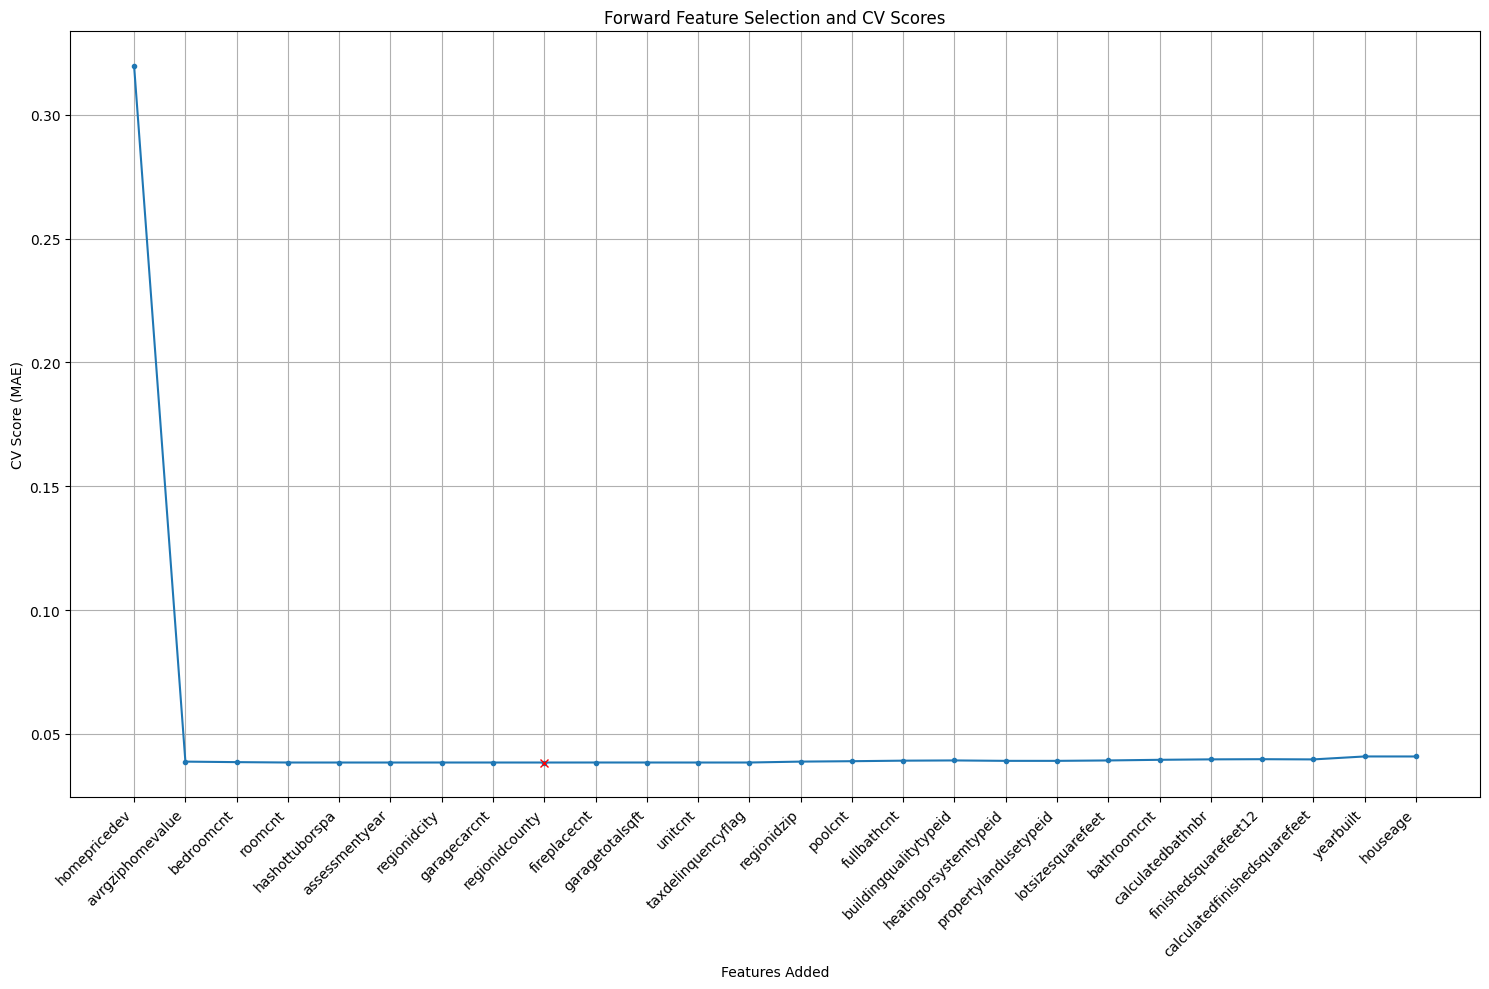

Results from forward feature selection using gradient boosting regressor

Best Feature Set: [25, 24, 1, 8, 18, 6, 9, 19, 15, 10]

Best Feature Set: ['homepricedev', 'avrgziphomevalue', 'bedroomcnt', 'garagecarcnt',
 'regionidzip', 'fireplacecnt', 'garagetotalsqft', 'unitcnt', 'regionidcity', 'hashottuborspa']

Best CV Score: 0.0384

 0 'bathroomcnt',1  'bedroomcnt',2  'buildingqualitytypeid',
      3  'calculatedbathnbr', 4 'calculatedfinishedsquarefeet',
 5 'finishedsquarefeet12', 6 'fireplacecnt', 7 'fullbathcnt', 8 'garagecarcnt',
 9 'garagetotalsqft', 10 'hashottuborspa', 11 'heatingorsystemtypeid',
 12 'lotsizesquarefeet',13 'poolcnt', 14 'propertylandusetypeid',15  'regionidcity',
 16 'regionidcounty', 17 'regionidzip', 18 'roomcnt',19  'unitcnt', 20 'yearbuilt',
 21 'assessmentyear', 22 'taxdelinquencyflag', 23 'houseage', 24 'avrgziphomevalue',
25 'homepricedev'],



Results from running a second time:

Best Feature Set: ['homepricedev', 'avrgziphomevalue', 'bedroomcnt', 'roomcnt', 'hashottuborspa', 'assessmentyear', 'regionidcity', 'garagecarcnt', 'regionidcounty']

Best CV Score: 0.0384

Index(['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt',
       'garagetotalsqft', 'hashottuborspa', 'heatingorsystemtypeid',
       'lotsizesquarefeet', 'poolcnt', 'propertylandusetypeid', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt',
       'assessmentyear', 'taxdelinquencyflag', 'houseage', 'avrgziphomevalue',
       'homepricedev'],
      dtype='object')


Results from running only the best features:
Gradient Boosting Trees
CV MAE Score Mean:  0.03874435857443474
CV MAE Score StDev:  0.0010675077218170173

Results from running a 3rd time this time with cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state, )

Best Feature Set: ['homepricedev', 'avrgziphomevalue', 'assessmentyear', 'roomcnt', 'fireplacecnt', 'garagetotalsqft']

Best CV Score: 0.0385

Index(['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt',
       'garagetotalsqft', 'hashottuborspa', 'heatingorsystemtypeid',
       'lotsizesquarefeet', 'poolcnt', 'propertylandusetypeid', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt',
       'assessmentyear', 'taxdelinquencyflag', 'houseage', 'avrgziphomevalue',
       'homepricedev'],
      dtype='object')

In [ ]:
X_best_features_gr = X_transformed_scaled[['homepricedev', 'avrgziphomevalue', 'bedroomcnt', 'roomcnt', 'hashottuborspa', 'assessmentyear', 'regionidcity', 'garagecarcnt', 'regionidcounty']]

In [ ]:
cv_scores_gb_3 = -1* cross_val_score(model_gb, X_best_features_gr, y_transformed, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state, ), scoring = 'neg_mean_absolute_error')


In [ ]:
print("Gradient Boosting Trees")
print("CV MAE Score Mean: ", cv_scores_gb_3.mean())
print("CV MAE Score StDev: ", cv_scores_gb_3.std())

Gradient Boosting Trees
CV MAE Score Mean:  0.03874435857443474
CV MAE Score StDev:  0.0010675077218170173


Gradient Boosting Trees Results (with log transformation of y)
- Best Feature Set:  ['homepricedev', 'avrgziphomevalue', 'assessmentyear', 'roomcnt', 'fireplacecnt', 'garagetotalsqft']
- CV MAE Score Mean:  0.03874435857443474
- CV MAE Score StDev:  0.0010675077218170173

In [ ]:
# Gradient Boosting Trees (with home price dev)

sel_features_gb, b_scores_gb, b_feature_sets_gb, b_score_gb = forward_feature_selection(X_transformed_scaled, y_train, model_gb)

In [ ]:

index = np.argmax(np.array(sel_features_gb) == b_feature_sets_gb[-1])

plt.figure(figsize=(15, 10))
plt.plot(range(1, len(b_scores_gb) + 1), b_scores_gb, marker='.')
plt.plot([index+1],b_score_gb,marker='x',color='red')
plt.xticks(range(1, len(sel_features_gb) + 1), sel_features_gb, rotation=45, ha='right')
plt.title('Forward Feature Selection and CV Scores')
plt.xlabel('Features Added')
plt.ylabel('CV Score (MAE)')
plt.grid()
plt.tight_layout()
plt.show()

print(f"Best Feature Set: {b_feature_sets_gb}")
print(f"Best CV Score: {b_score_gb:.4f}")


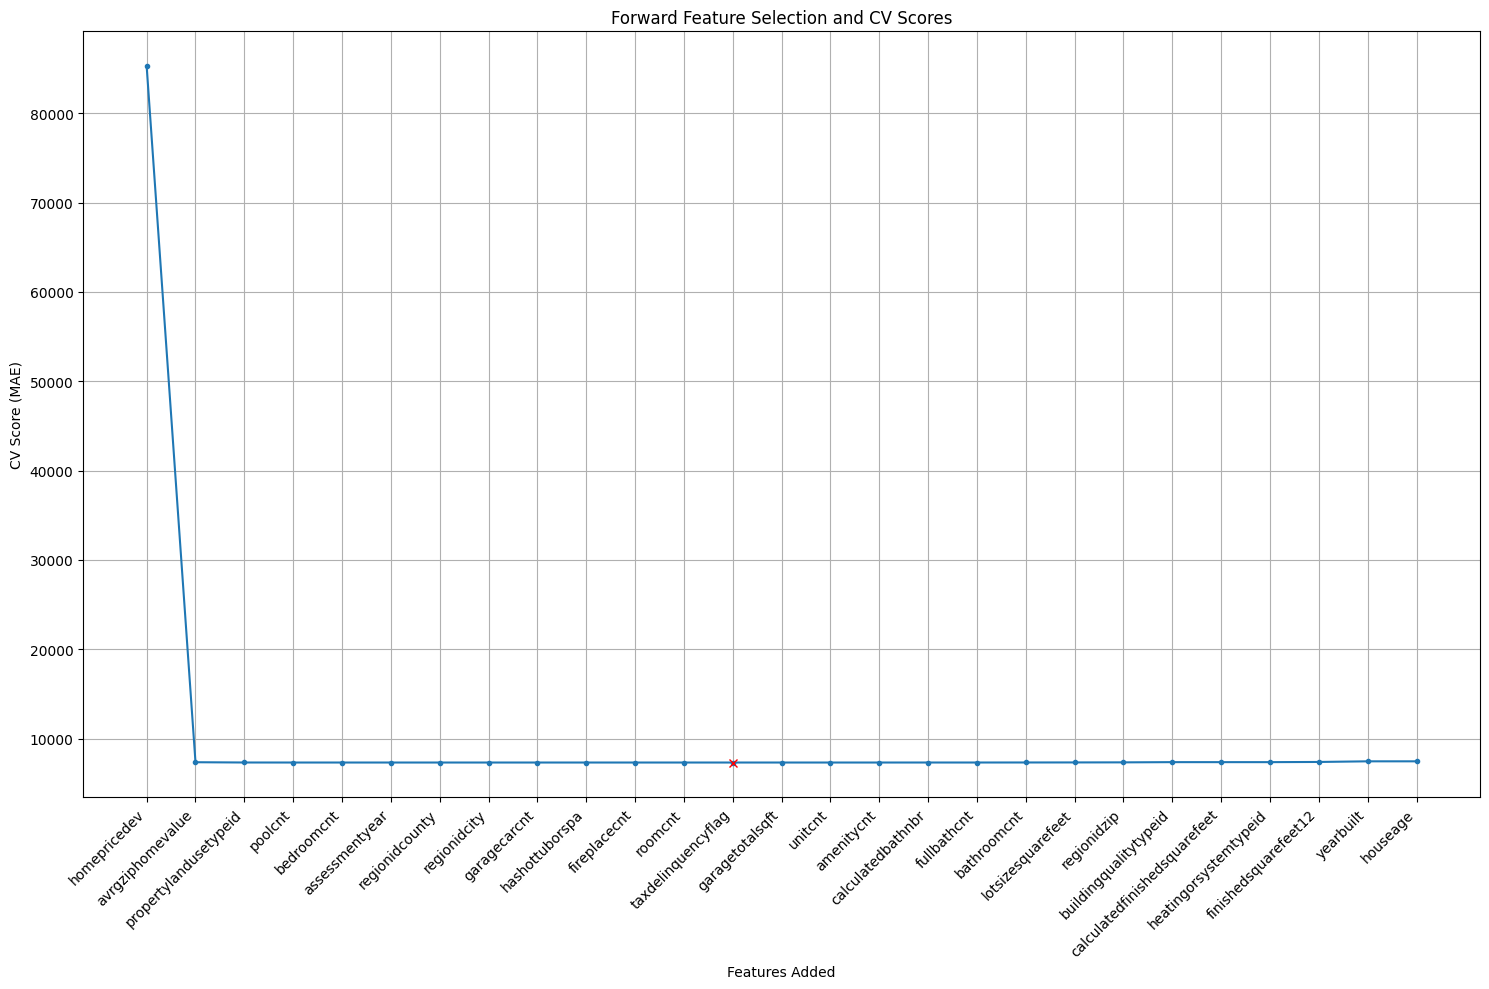

Gradient Boosting Trees Results (with home price dev)
- Best Feature Set: ['homepricedev', 'avrgziphomevalue', 'propertylandusetypeid', 'poolcnt', 'bedroomcnt', 'assessmentyear', 'regionidcounty', 'regionidcity', 'garagecarcnt', 'hashottuborspa', 'fireplacecnt', 'roomcnt', 'taxdelinquencyflag']
- Best CV Score: $7,314.87

In [ ]:
# Gradient Boosting Trees (without home price dev)

# Scores from part 2
# CV MAE Score Mean: $131,782.87
# CV MAE Score StDev: $651.69

model_gb = GradientBoostingRegressor(random_state=random_state)

sel_features_gb, b_scores_gb, b_feature_sets_gb, b_score_gb = forward_feature_selection(X_transformed_scaled, y_train, model_gb)

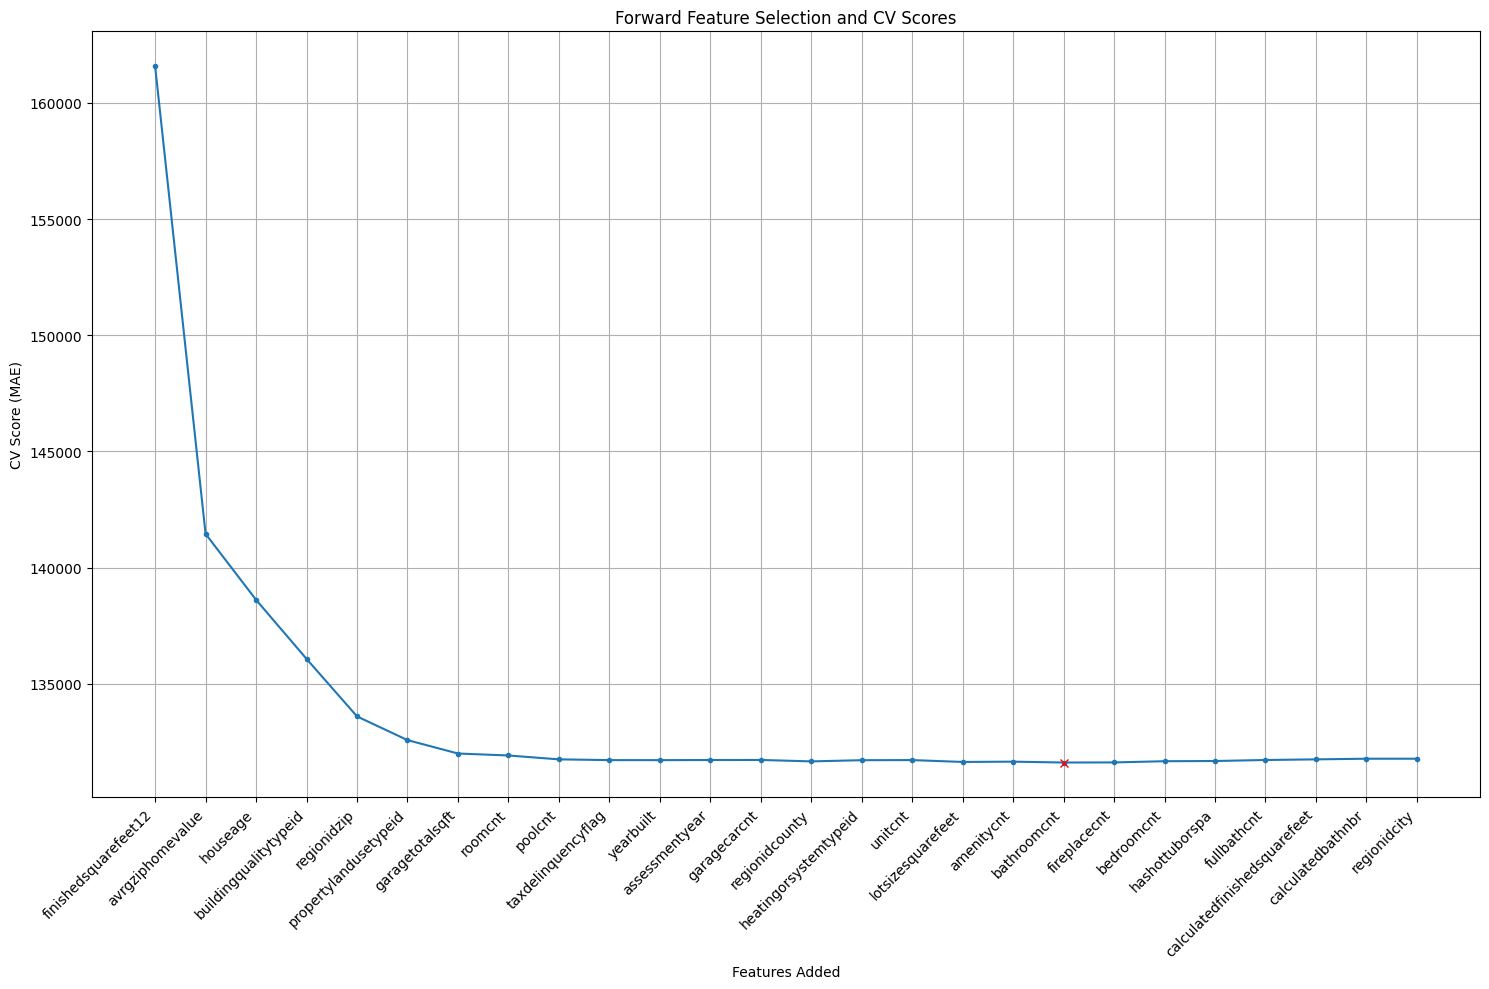

Best Feature Set: ['finishedsquarefeet12', 'avrgziphomevalue', 'houseage', 'buildingqualitytypeid', 'regionidzip', 'propertylandusetypeid', 'garagetotalsqft', 'roomcnt', 'poolcnt', 'taxdelinquencyflag', 'yearbuilt', 'assessmentyear', 'garagecarcnt', 'regionidcounty', 'heatingorsystemtypeid', 'unitcnt', 'lotsizesquarefeet', 'amenitycnt', 'bathroomcnt']
Best CV Score: 131606.9931


In [ ]:
index = np.argmax(np.array(sel_features_gb) == b_feature_sets_gb[-1])

plt.figure(figsize=(15, 10))
plt.plot(range(1, len(b_scores_gb) + 1), b_scores_gb, marker='.')
plt.plot([index+1],b_score_gb,marker='x',color='red')
plt.xticks(range(1, len(sel_features_gb) + 1), sel_features_gb, rotation=45, ha='right')
plt.title('Forward Feature Selection and CV Scores')
plt.xlabel('Features Added')
plt.ylabel('CV Score (MAE)')
plt.grid()
plt.tight_layout()
plt.show()

print(f"Best Feature Set: {b_feature_sets_gb}")
print(f"Best CV Score: {b_score_gb:.4f}")

In [ ]:
X_best_features_gr = X_transformed_scaled[['finishedsquarefeet12', 'avrgziphomevalue', 'houseage', 'buildingqualitytypeid', 'regionidzip', 'propertylandusetypeid', 'garagetotalsqft', 'roomcnt', 'poolcnt', 'taxdelinquencyflag', 'yearbuilt', 'assessmentyear', 'garagecarcnt', 'regionidcounty', 'heatingorsystemtypeid', 'unitcnt', 'lotsizesquarefeet', 'amenitycnt', 'bathroomcnt']]

In [ ]:
cv_scores_gb_3 = -1 * cross_val_score(model_gb, X_best_features_gr, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state, ), scoring = 'neg_mean_absolute_error')


In [ ]:
print("Gradient Boosting Trees")
print(f'CV MAE Score Mean: ${cv_scores_gb_3.mean():,.2f}')
print(f'CV MAE Score StDev: ${cv_scores_gb_3.std():,.2f}')

Gradient Boosting Trees
CV MAE Score Mean: $131,681.54
CV MAE Score StDev: $697.79


Gradient Boosting Trees Results (without home price dev)
- Best Feature Set: ['finishedsquarefeet12', 'avrgziphomevalue', 'houseage', 'buildingqualitytypeid', 'regionidzip', 'propertylandusetypeid', 'garagetotalsqft', 'roomcnt', 'poolcnt', 'taxdelinquencyflag', 'yearbuilt', 'assessmentyear', 'garagecarcnt', 'regionidcounty', 'heatingorsystemtypeid', 'unitcnt', 'lotsizesquarefeet', 'amenitycnt', 'bathroomcnt']
- CV MAE Score Mean: 131,681.54 dollars
- CV MAE Score StDev: 697.79 dollars


**Bagging Model (Forward Feature Selection)**

In [ ]:
# Bagging Model (with home price dev)

model_bagging = BaggingRegressor(random_state=random_state)

sel_features_bagging, b_scores_bagging, b_feature_sets_bagging, b_score_bagging = forward_feature_selection(X_transformed_scaled, y_train, model_bagging)

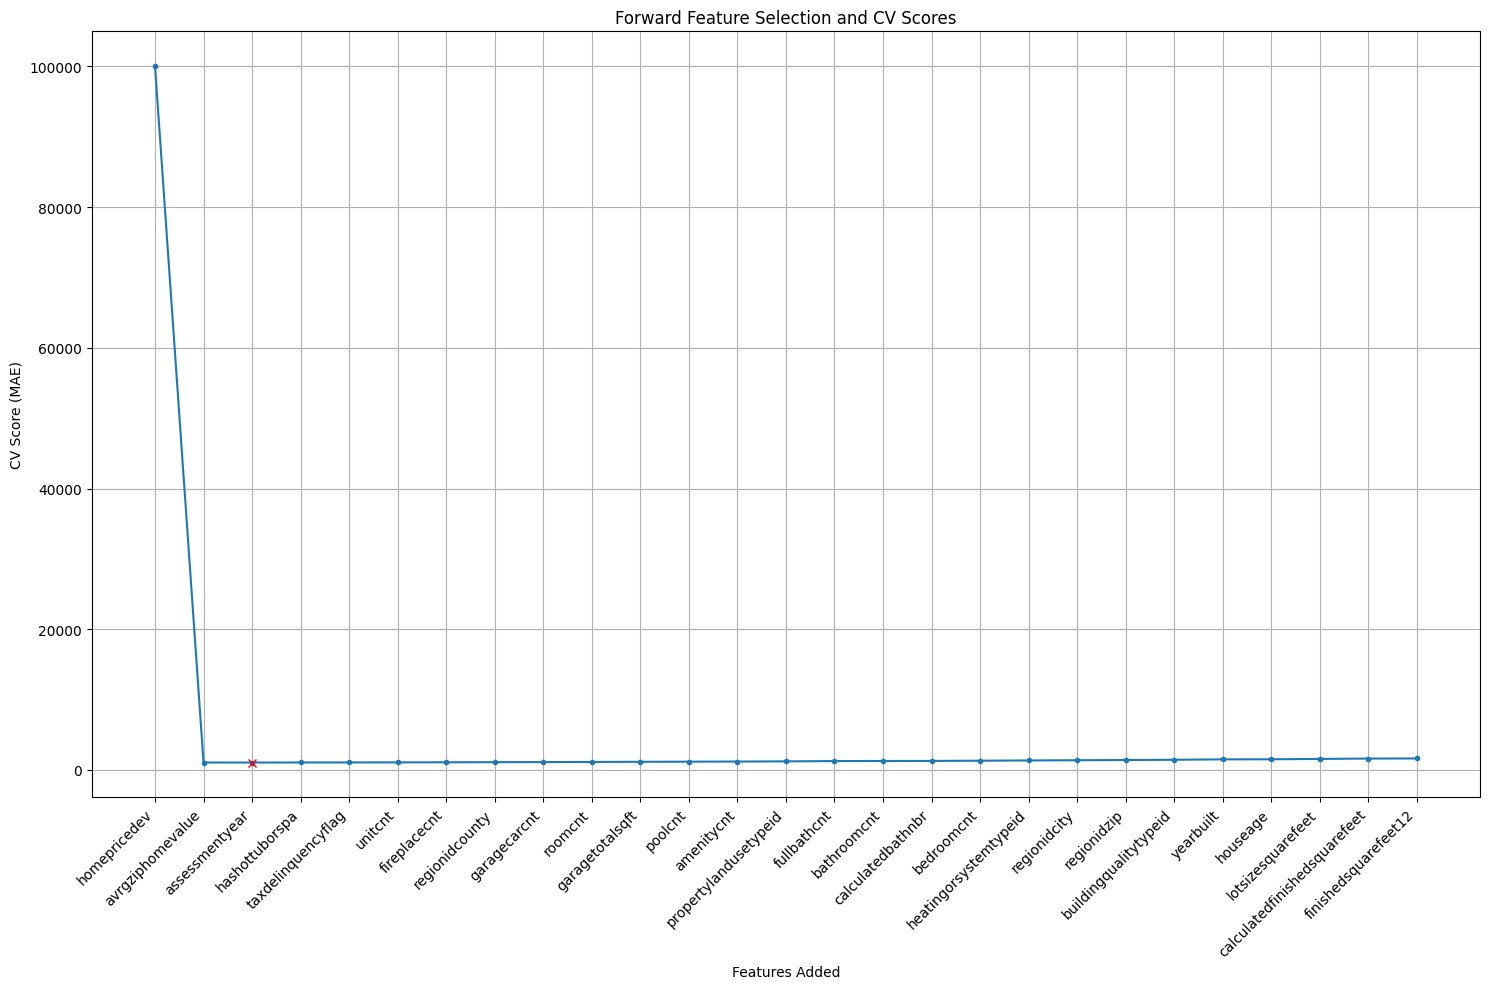

Best Feature Set: ['homepricedev', 'avrgziphomevalue', 'assessmentyear']
Best CV Score: 1054.3976


In [ ]:
index = np.argmax(np.array(sel_features_bagging) == b_feature_sets_bagging[-1])

plt.figure(figsize=(15, 10))
plt.plot(range(1, len(b_scores_bagging) + 1), b_scores_bagging, marker='.')
plt.plot([index+1],b_score_bagging,marker='x',color='red')
plt.xticks(range(1, len(sel_features_bagging) + 1), sel_features_bagging, rotation=45, ha='right')
plt.title('Forward Feature Selection and CV Scores')
plt.xlabel('Features Added')
plt.ylabel('CV Score (MAE)')
plt.grid()
plt.tight_layout()
plt.show()

print(f"Best Feature Set: {b_feature_sets_bagging}")
print(f"Best CV Score: {b_score_bagging:.4f}")

In [ ]:
X_best_features_bagging = X_transformed_scaled[['homepricedev', 'avrgziphomevalue', 'assessmentyear']]

In [ ]:
cv_scores_bagging_3a = -1 * cross_val_score(model_bagging, X_best_features_bagging, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state, ), scoring = 'neg_mean_absolute_error')


In [ ]:
print("Bagging")
print(f'CV MAE Score Mean: ${cv_scores_bagging_3a.mean():,.2f}')
print(f'CV MAE Score StDev: ${cv_scores_bagging_3a.std():,.2f}')


Bagging
CV MAE Score Mean: $1,059.78
CV MAE Score StDev: $23.75


Bagging Model Results (with home price dev)
- Best Feature Set: ['homepricedev', 'avrgziphomevalue',
'assessmentyear']
- CV MAE Score Mean: 1,059.78 dollars
- CV MAE Score StDev: 23.75 dollars

In [ ]:
# Bagging Model (without home price dev)

# Scores from part 2
# CV MAE Score Mean: $133,966.49
# CV MAE Score StDev: $958.66

model_bagging = BaggingRegressor(random_state=random_state)

sel_features_bagging, b_scores_bagging, b_feature_sets_bagging, b_score_bagging = forward_feature_selection(X_transformed_scaled, y_train, model_bagging)

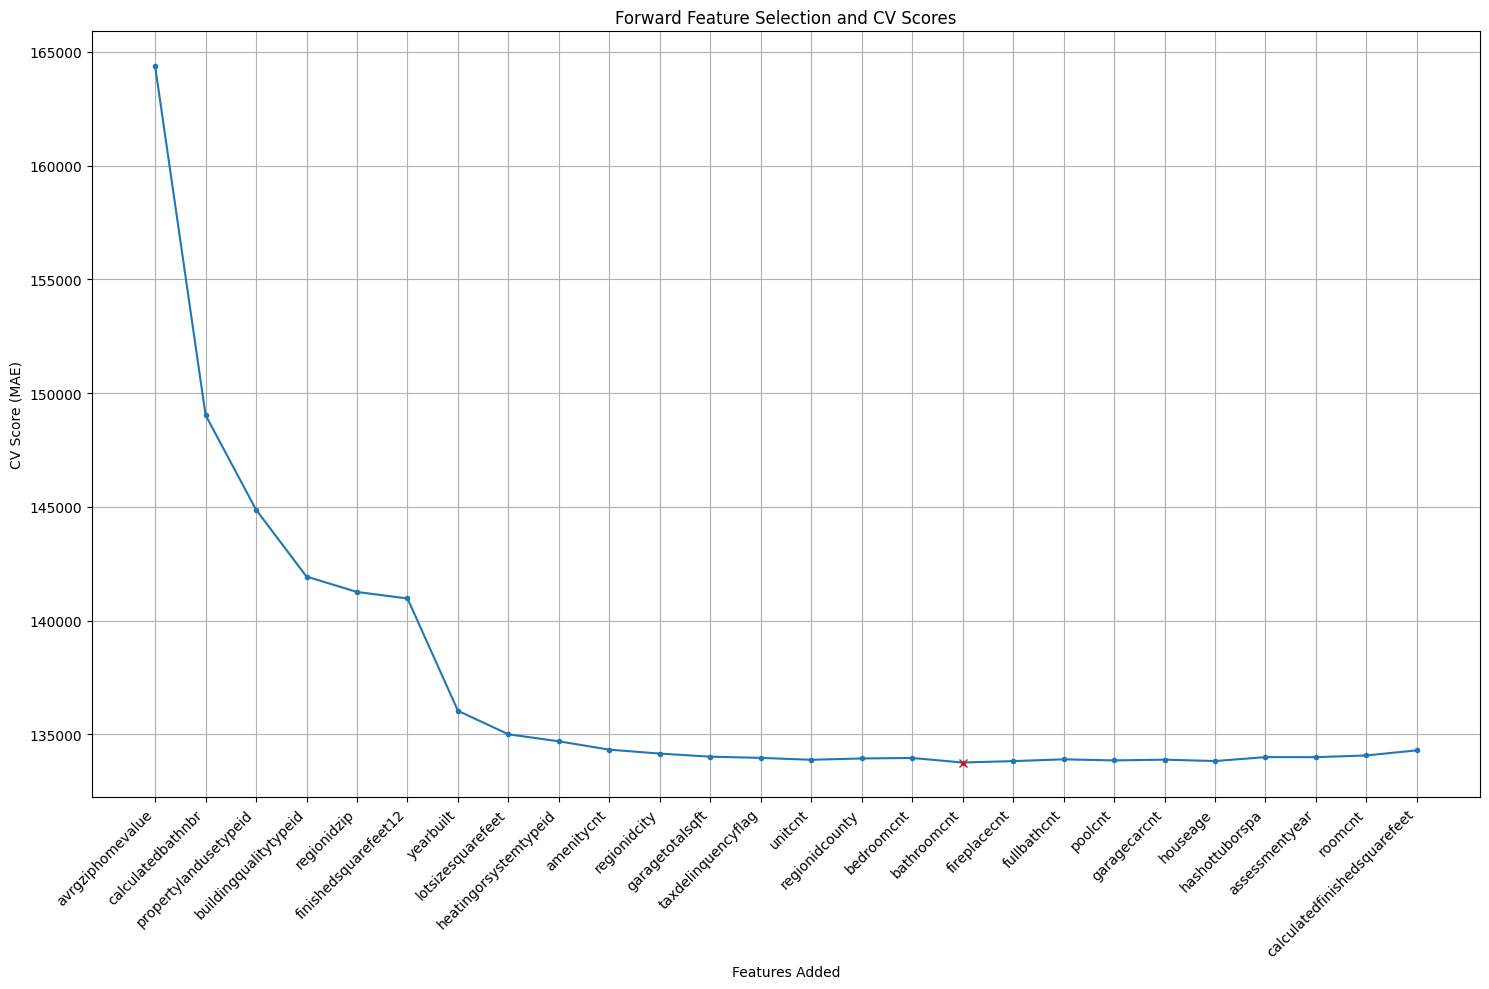

Best Feature Set: ['avrgziphomevalue', 'calculatedbathnbr', 'propertylandusetypeid', 'buildingqualitytypeid', 'regionidzip', 'finishedsquarefeet12', 'yearbuilt', 'lotsizesquarefeet', 'heatingorsystemtypeid', 'amenitycnt', 'regionidcity', 'garagetotalsqft', 'taxdelinquencyflag', 'unitcnt', 'regionidcounty', 'bedroomcnt', 'bathroomcnt']
Best CV Score: 133767.4426


In [ ]:
index = np.argmax(np.array(sel_features_bagging) == b_feature_sets_bagging[-1])

plt.figure(figsize=(15, 10))
plt.plot(range(1, len(b_scores_bagging) + 1), b_scores_bagging, marker='.')
plt.plot([index+1],b_score_bagging,marker='x',color='red')
plt.xticks(range(1, len(sel_features_bagging) + 1), sel_features_bagging, rotation=45, ha='right')
plt.title('Forward Feature Selection and CV Scores')
plt.xlabel('Features Added')
plt.ylabel('CV Score (MAE)')
plt.grid()
plt.tight_layout()
plt.show()

print(f"Best Feature Set: {b_feature_sets_bagging}")
print(f"Best CV Score: {b_score_bagging:.4f}")

In [ ]:
X_best_features_bagging = X_transformed_scaled[['avrgziphomevalue', 'calculatedbathnbr', 'propertylandusetypeid', 'buildingqualitytypeid', 'regionidzip', 'finishedsquarefeet12', 'yearbuilt', 'lotsizesquarefeet', 'heatingorsystemtypeid', 'amenitycnt', 'regionidcity', 'garagetotalsqft', 'taxdelinquencyflag', 'unitcnt', 'regionidcounty', 'bedroomcnt', 'bathroomcnt']]

In [ ]:
cv_scores_bagging_3b = -1 * cross_val_score(model_bagging, X_best_features_bagging, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state, ), scoring = 'neg_mean_absolute_error')

In [ ]:
print("Bagging")
print(f'CV MAE Score Mean: ${cv_scores_bagging_3b.mean():,.2f}')
print(f'CV MAE Score StDev: ${cv_scores_bagging_3b.std():,.2f}')

Bagging
CV MAE Score Mean: $134,305.92
CV MAE Score StDev: $1,000.14


Bagging Model Results (without home price dev)
- Best Feature Set: ['avrgziphomevalue', 'calculatedbathnbr', 'propertylandusetypeid', 'buildingqualitytypeid', 'regionidzip', 'finishedsquarefeet12', 'yearbuilt', 'lotsizesquarefeet', 'heatingorsystemtypeid', 'amenitycnt', 'regionidcity', 'garagetotalsqft', 'taxdelinquencyflag', 'unitcnt', 'regionidcounty', 'bedroomcnt', 'bathroomcnt']
- CV MAE Score Mean: 134,305.92 dollars
- CV MAE Score StDev: 1,000.14 dollars

**Random Forest Model (Forward Feature Selection)**

In [ ]:
# Random Forest (without home price dev)

# Scores from part 2
# CV MAE Score Mean: $129,761.66
# CV MAE Score StDev: $849.83

model_rf = RandomForestRegressor(random_state=random_state)

sel_features_rf, b_scores_rf, b_feature_sets_rf, b_score_rf = forward_feature_selection(X_transformed_scaled, y_train, model_rf)

In [ ]:
index = np.argmax(np.array(sel_features_rf) == b_feature_sets_rf[-1])

plt.figure(figsize=(15, 10))
plt.plot(range(1, len(b_scores_rf) + 1), b_scores_rf, marker='.')
plt.plot([index+1],b_score_rf,marker='x',color='red')
plt.xticks(range(1, len(sel_features_rf) + 1), sel_features_rf, rotation=45, ha='right')
plt.title('Forward Feature Selection and CV Scores')
plt.xlabel('Features Added')
plt.ylabel('CV Score (MAE)')
plt.grid()
plt.tight_layout()
plt.show()

print(f"Best Feature Set: {b_feature_sets_rf}")
print(f"Best CV Score: {b_score_rf:.4f}")

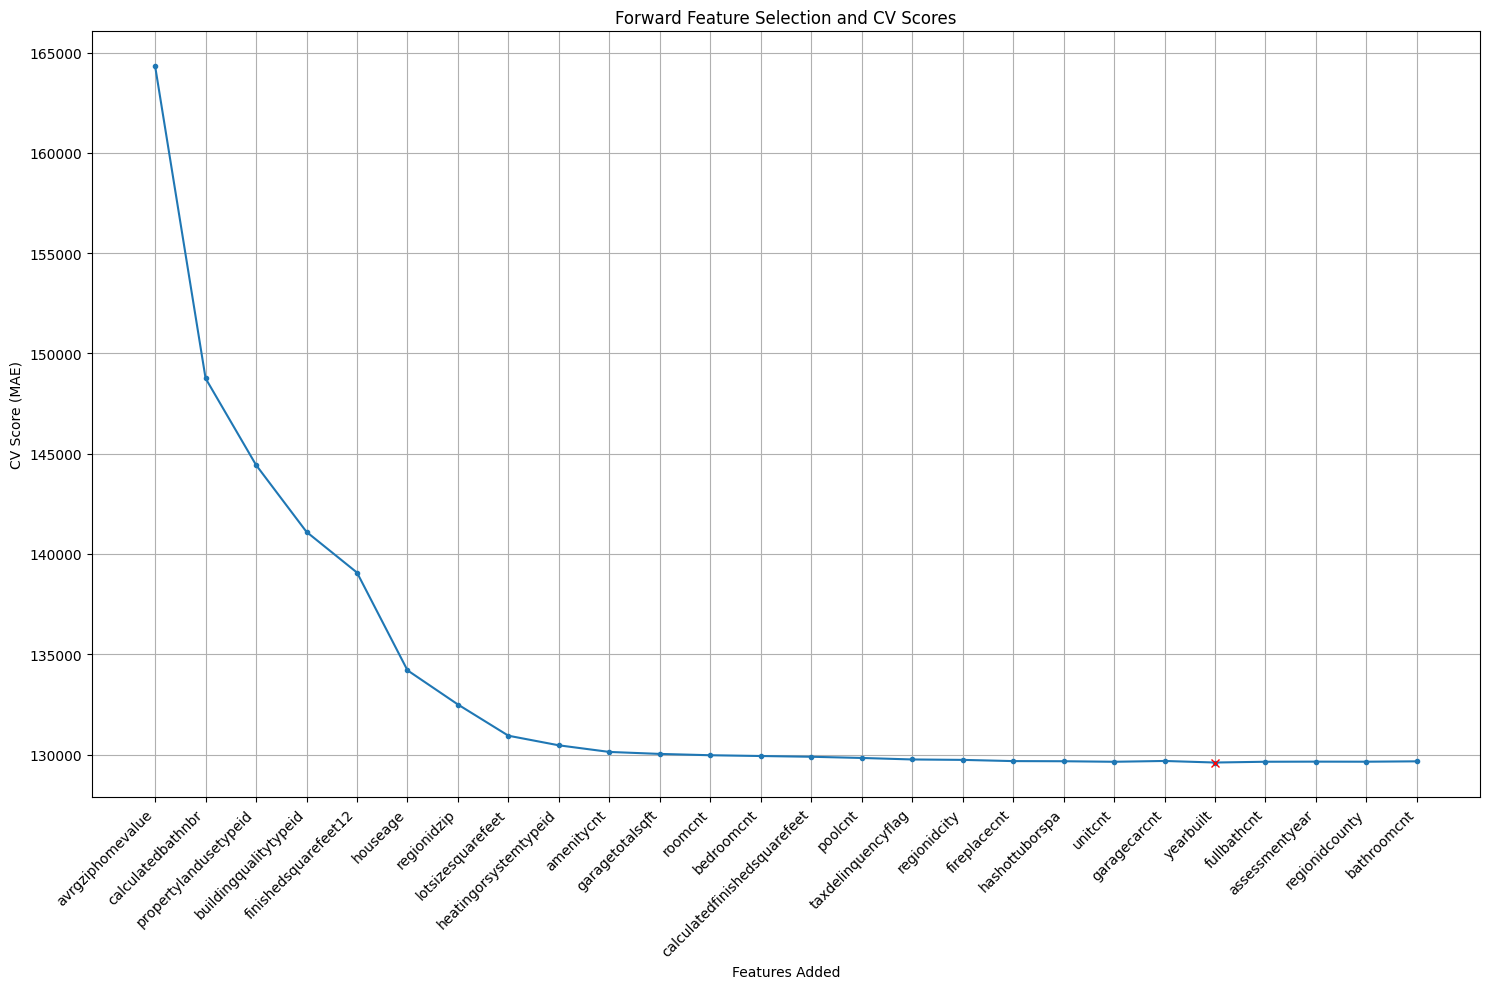

Best Feature Set: ['avrgziphomevalue', 'calculatedbathnbr', 'propertylandusetypeid', 'buildingqualitytypeid', 'finishedsquarefeet12', 'houseage', 'regionidzip', 'lotsizesquarefeet', 'heatingorsystemtypeid', 'amenitycnt', 'garagetotalsqft', 'roomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'poolcnt', 'taxdelinquencyflag', 'regionidcity', 'fireplacecnt', 'hashottuborspa', 'unitcnt', 'garagecarcnt', 'yearbuilt']

Best CV Score: 129600.5261

In [ ]:
X_best_features_rf = X_transformed_scaled[['avrgziphomevalue', 'calculatedbathnbr', 'propertylandusetypeid', 'buildingqualitytypeid', 'finishedsquarefeet12', 'houseage', 'regionidzip', 'lotsizesquarefeet', 'heatingorsystemtypeid', 'amenitycnt', 'garagetotalsqft', 'roomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'poolcnt', 'taxdelinquencyflag', 'regionidcity', 'fireplacecnt', 'hashottuborspa', 'unitcnt', 'garagecarcnt', 'yearbuilt']]

In [ ]:
model_rf = RandomForestRegressor(random_state=random_state)

cv_scores_rf_3 = -1 * cross_val_score(model_rf, X_best_features_rf, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state, ), scoring = 'neg_mean_absolute_error')


In [ ]:
print("Random Forest")
print(f'CV MAE Score Mean: ${cv_scores_rf_3.mean():,.2f}')
print(f'CV MAE Score StDev: ${cv_scores_rf_3.std():,.2f}')

Random Forest
CV MAE Score Mean: $129,795.54
CV MAE Score StDev: $824.61


Random Forest Model Results (without home price dev)
- Best Feature Set: ['avrgziphomevalue', 'calculatedbathnbr', 'propertylandusetypeid', 'buildingqualitytypeid', 'finishedsquarefeet12', 'houseage', 'regionidzip', 'lotsizesquarefeet', 'heatingorsystemtypeid', 'amenitycnt', 'garagetotalsqft', 'roomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'poolcnt', 'taxdelinquencyflag', 'regionidcity', 'fireplacecnt', 'hashottuborspa', 'unitcnt', 'garagecarcnt', 'yearbuilt']
- CV MAE Score Mean: 129,795.54 dollars
- CV MAE Score StDev: 824.61 dollars

### Part 3: Discussion [3 pts]

Analyze the effect of feature selection on your models:

- Did performance improve for any models after reducing the number of features?

- Which features were consistently retained across models?

- Were any of your newly engineered features selected as important?


### Results Summary

| Model             | Part 1 CV MAE | Part 1 STD | Part 2 CV MAE | Part 2 STD | Part 3 CV MAE | Part 3 STD |
|-------------------|---------------|------------|---------------|------------|---------------|------------|
| Gradient Boosting  | 136,362.48    | 806.22     | 131,782.87    | 651.69     | 131,681.54    | 697.79     |
| Bagging           | 136,749.43    | 1,023.46   | 133,966.49    | 958.66     | 134,305.92    | 1,000.14   |
| Random Forest     | 131,885.24    | 841.50     | 129,761.66    | 849.83     | 129,795.54    | 824.61     |


The performance of the models did not seem to signifcantly improve after reducing the number of features. Between 17-22 features were selected as the best features in the models. Some features consistently retained include:
- 'finishedsquarefeet12'
- 'avrgziphomevalue',
- 'buildingqualitytypeid', '
- regionidzip',  
- 'propertylandusetypeid',
-'garagetotalsqft',
-'taxdelinquencyflag',
-'yearbuilt',
-'heatingorsystemtypeid',
-'unitcnt',
-'lotsizesquarefeet', '
-'amenitycnt'

Of our newly engineered features, all three - house age, average home value per zip code and amenity count - were selected as important in the Gradient Boosting Trees model and the Random Forest model. Average home value per zip code and amentity count were also selected for the Bagging model.

We also had tried feature selection with the dataset that include the previously mentioned home price deviation feature that we had engineered; however, after noticing in the Bagging model that it was one of only three features selected, we decided to remove it due to overfitting.

### Part 4: Fine-Tuning Your Three Models [6 pts]

In this final phase of Milestone 2, you’ll select and refine your **three most promising models and their corresponding data pipelines** based on everything you've done so far, and pick a winner!

1. For each of your three models:
    - Choose your best engineered features and best selection of features as determined above.
   - Perform hyperparameter tuning using `sweep_parameters`, `GridSearchCV`, `RandomizedSearchCV`, `Optuna`, etc. as you have practiced in previous homeworks.
3. Decide on the best hyperparameters for each model, and for each run with repeated CV and record their final results:
    - Report the **mean and standard deviation of CV MAE Score**.  

**Gradient Boosting Trees (Sweep_Parameters and RandomizedSearchCV)**

In [ ]:
from sklearn.metrics         import mean_absolute_error
def run_model(model,
              X_train, y_train,
              n_repeats=5,
              n_jobs=-1,
              **model_params
             ):

    # Instantiate the model if a class is provided
    if isinstance(model, type):
        model = model(**model_params)
    else:
        model.set_params(**model_params)

    # Use negative MAE for cross-validation (since sklearn minimizes loss)
    neg_mae_scores = cross_val_score(
        model,
        X_train, y_train,
        scoring='neg_mean_absolute_error',
        cv=RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=random_state),
        n_jobs=n_jobs
    )

    mean_cv_mae = -np.mean(neg_mae_scores)
    std_cv_mae  =  np.std(neg_mae_scores)

    # Fit the model on the full training set
    model.fit(X_train, y_train)

    # Compute training MAE
    train_preds = model.predict(X_train)
    train_mae   = mean_absolute_error(y_train, train_preds)

    return mean_cv_mae, std_cv_mae, train_mae

In [ ]:
import time

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,              # Defined above
                    y_train          = y_train,
                    verbose          = True,
                    show_mae         = True,
                    show_std         = False,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 5
                   ):


    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary

    cv_maes, std_cvs, train_maes = [], [], []
    no_improve_count = 0
    best_mae = float('inf')

    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        P_temp.pop('MAE_found', None)  # Just in case

        cv_mae, std_cv, train_mae = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_maes.append(cv_mae)
        std_cvs.append(std_cv)
        train_maes.append(train_mae)

        if cv_mae < best_mae - delta:
            best_mae = cv_mae
            no_improve_count = 0
        else:
            no_improve_count += 1

        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break

    # Identify best parameter
    min_cv_mae = min(cv_maes)
    min_index = cv_maes.index(min_cv_mae)
    best_param = parameter_list[min_index]
    Parameters[param] = best_param
    Parameters['MAE_found'] = min_cv_mae

    # ---------- Plotting section ----------
    if verbose:
        partial_param_list = parameter_list[:len(cv_maes)]

        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            x_vals = partial_param_list
            x_labels = partial_param_list

        error_name = 'MAE'

        # Create appropriate number of subplots
        if show_std:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        else:
            fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))

        ax1.set_title(f"{error_name} vs {param}")
        if show_mae:
            ax1.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))

        ax1.plot(x_vals,
                 cv_maes,
                 marker='.', label="CV MAE", color='blue')
        ax1.plot(x_vals,
                 train_maes,
                 marker='.', label="Train MAE", color='green')
        ax1.scatter([x_vals[min_index]],
                    [min_cv_mae],
                    marker='x', label="Best CV MAE", color='red')

        ax1.set_ylabel(error_name)
        ax1.legend()
        ax1.grid()

        # Optional Std Dev Plot
        if show_std:
            ax2.set_title(f"CV Standard Deviation vs {param}")
            ax2.plot(x_vals, std_cvs, marker='.', label="CV MAE Std", color='blue')
            ax2.set_xlabel(param)
            ax2.set_ylabel("Standard Deviation")
            ax2.legend()
            ax2.grid(alpha=0.5)

            if is_boolean:
                ax2.set_xticks(x_vals)
                ax2.set_xticklabels(x_labels)
        else:
            ax1.set_xlabel(param)
            if is_boolean:
                ax1.set_xticks(x_vals)
                ax1.set_xticklabels(x_labels)

        plt.tight_layout()
        plt.show()

        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))

    return Parameters

In [ ]:
# Default parameters for gradient boosting
Default_Parameters_GB = {
    'n_estimators'            : 100,             # The number of boosting stages to be run. More estimators can improve performance but increase training time.
    'max_depth'               : 3,               # Maximum depth of individual trees. Controls model complexity.
    'max_features'            : None,            # Number of features to consider when looking for best split. Can help reduce overfitting.
    'min_samples_split'       : 2,               # Defines the minimum number of samples required to split an internal node.
    'min_samples_leaf'        : 1,               # Specifies the minimum number of samples that must be present in a leaf node.
    'random_state'            : random_state,     # Controls randomness of boosting. Useful for reproducibility.
    'MAE_found'               : float('inf')     # NOT a model parameter, but will record the MAE found for the current parameter choices
}

In [ ]:
Params_GB = Default_Parameters_GB.copy()

In [ ]:
Params_GB_1 = sweep_parameter(GradientBoostingRegressor,
                            Params_GB, 'n_estimators', range(1, 1001, 100), X_train = X_best_features_gr)

Sweeping n_estimators:  90%|█████████ | 9/10 [2:09:29<21:34, 1294.38s/it]

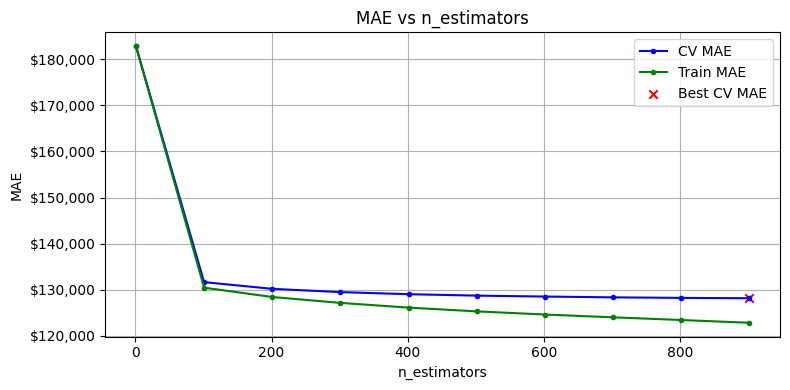

Sweeping max_depth: 100%|██████████| 5/5 [1:08:21<00:00, 820.27s/it] 


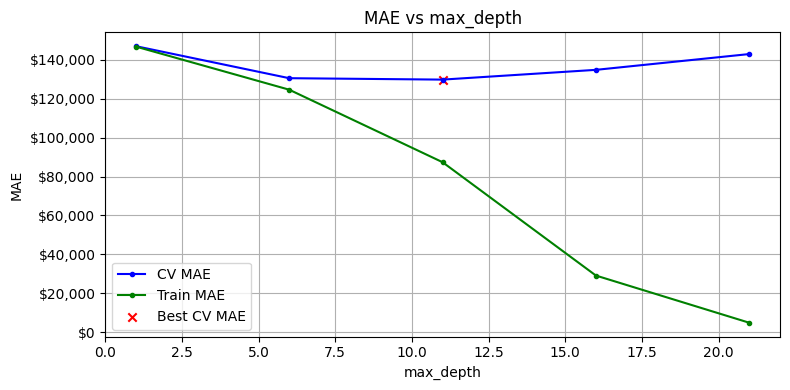

Execution Time: 01:08:21


In [ ]:
Params_GB_2 = sweep_parameter(GradientBoostingRegressor,
                            Params_GB, 'max_depth', range(1, 26, 5), X_train = X_best_features_gr)

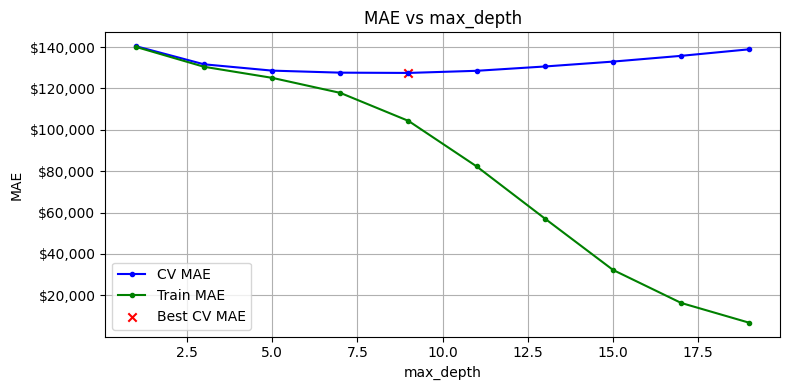

Sweeping max_features: 100%|██████████| 5/5 [04:53<00:00, 58.64s/it]


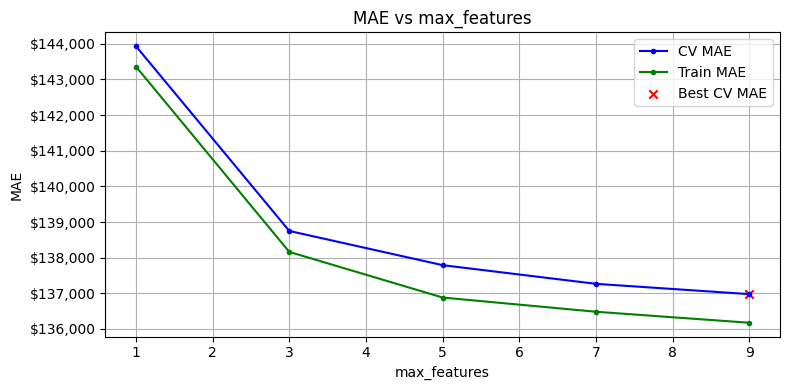

Execution Time: 00:04:53


In [ ]:
Params_GB_3 = sweep_parameter(GradientBoostingRegressor,
                            Params_GB, 'max_features', range(1, 10, 2). X_train = X_best_features_gr)

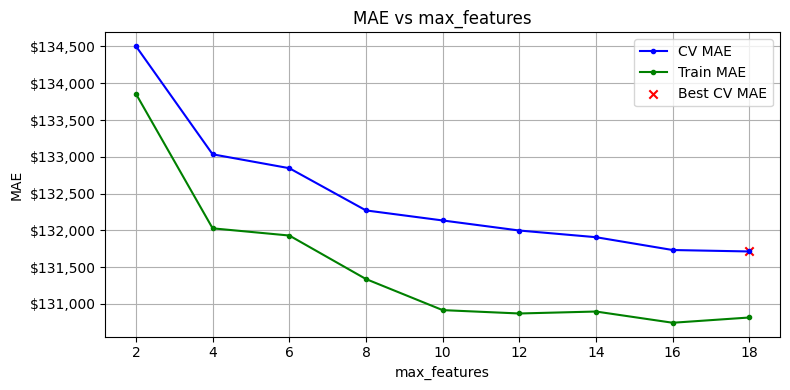

In [ ]:
Params_GB_4 = sweep_parameter(GradientBoostingRegressor,
                            Params_GB, 'min_samples_split', range(1, 10, 2), X_train = X_best_features_gr)

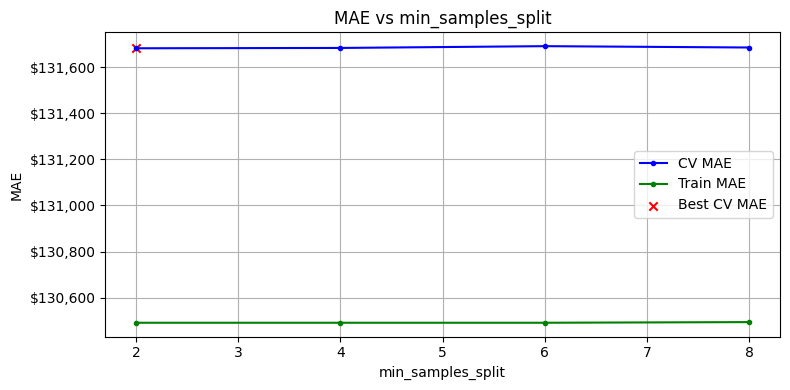

In [ ]:
Params_GB_5 = sweep_parameter(GradientBoostingRegressor,
                            Params_GB, 'min_samples_leaf', range(1, 10, 2), X_train = X_best_features_gr)



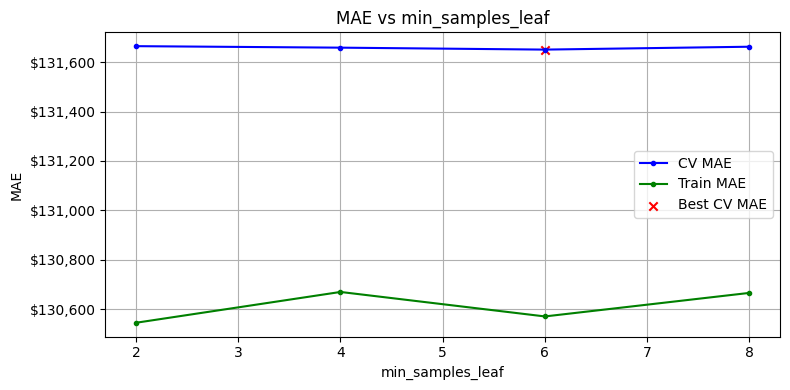

In [ ]:
# RANDOM SEARCH
from scipy.stats import randint
n_iterations = 10            # How many samples to take from the distributions shown here (rest are defaults):

param_distributions = {
    'n_estimators'      : randint(800, 1000),
    'max_depth'         : randint(7, 10),
    'max_features'      : randint(17,19),
    'min_samples_split' : randint(2,4),
    'min_samples_leaf'  : randint(5,7),
}

# Set up X train and y train
X_train_now = X_best_features_gr
y_train_now = y_train
# Initialize the GradientBoostingRegressor
model_gb = GradientBoostingRegressor(random_state=random_state)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator           = model_gb,
    param_distributions = param_distributions,
    n_iter              = n_iterations,
    cv                  = 5,
    random_state        = random_state,
    n_jobs              = -1,
    verbose             = 1,
    scoring             = 'neg_mean_absolute_error'
)

# Fit the model
random_search.fit(X_train_now, y_train_now)

# Output the best parameters and scores
print("Best parameters:",             random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Convert the CV results to a DataFrame
# results_df = pd.DataFrame(random_search.cv_results_)

# Sort by mean test score (higher is better for negative MSE) and select the top 10
# top10 = results_df.sort_values(by="mean_test_score", ascending=False).head(10)

# Print out the 10 best models with their parameters and scores
# print("Top 10 models:")
# print(top10[["params", "mean_test_score", "std_test_score"]])

# print("Test set score:",              random_search.score(X_test, y_test))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
# Gradient Boosting Trees Model with Best Hyperparameters

model_gb = GradientBoostingRegressor(n_estimators=738,
                                max_depth = 4,
                                max_features = 12,
                                min_samples_leaf=1,
                                min_samples_split=2,
                                random_state = random_state)

model_gb.fit(X_best_features_gb, y_train)

cv_scores_gb_4 = -1 * cross_val_score(model_gb, X_best_features_gb, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state, ), scoring = 'neg_mean_absolute_error')

print("Gradient Boosting Trees Model")
print(f'CV MAE Score Mean: ${cv_scores_gb_4.mean():,.2f}')
print(f'CV MAE Score StDev: ${cv_scores_gb_4.std():,.2f}')

**Bagging (Sweep_Parameters and RandomizedSearchCV)**

In [ ]:
X_best_features_bagging = X_transformed_scaled[['avrgziphomevalue', 'calculatedbathnbr', 'propertylandusetypeid', 'buildingqualitytypeid', 'regionidzip', 'finishedsquarefeet12', 'yearbuilt', 'lotsizesquarefeet', 'heatingorsystemtypeid', 'amenitycnt', 'regionidcity', 'garagetotalsqft', 'taxdelinquencyflag', 'unitcnt', 'regionidcounty', 'bedroomcnt', 'bathroomcnt']]

In [ ]:
def run_bagging_regressor(X_best_features_bagging,
                             y_train,
                             estimator    = DecisionTreeRegressor(), # defaults
                             n_estimators = 10,
                             max_samples  = 1.0,
                             max_features = 1.0,
                             random_state = random_state,
                             cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state),         # Number of folds for cross-validation
                             n_jobs = -1
                            ):

    bagging_model = BaggingRegressor(
        estimator    = estimator,
        n_estimators = n_estimators,
        max_samples  = max_samples,
        max_features = max_features,
        n_jobs       = n_jobs,
        random_state = random_state
    )

    # Perform cross-validation and return mean CV MAE
    neg_mae_scores = cross_val_score(bagging_model, X_best_features_bagging, y_train,
                                     scoring='neg_mean_absolute_error',
                                     cv=cv,
                                     n_jobs=n_jobs
                                    )
    mean_cv_mae = -np.mean(neg_mae_scores)             # Convert negative MAE back to positive

    return mean_cv_mae

# Baseline using defaults
baseline_mae = run_bagging_regressor(X_best_features_bagging, y_train,n_jobs=-1)

print(f'Baseline MAE: {baseline_mae:.4f}')

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

In [ ]:

# n_estimators

start = time.time()

parameter_list = range(50,1001,10)

param = 'n_estimators'                  # <= and here

MAEs = []

for n in tqdm(parameter_list):

    MAEs.append( run_bagging_regressor(X_best_features_bagging,y_train,
                                       n_estimators = n,                  #  <= and here
                                       max_samples  = 1.0,
                                       max_features = 1.0
                                      ) )

# Find the minimum value
min_MAE = min(MAEs)

# Find the index of the minimum value
min_index = MAEs.index(min_MAE)

plt.figure(figsize=(6, 4))
plt.title("Bagging Regressor: MAE vs "+param)
plt.plot(parameter_list, MAEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MAE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MAE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MAE {min_MAE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MAE {min_MAE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

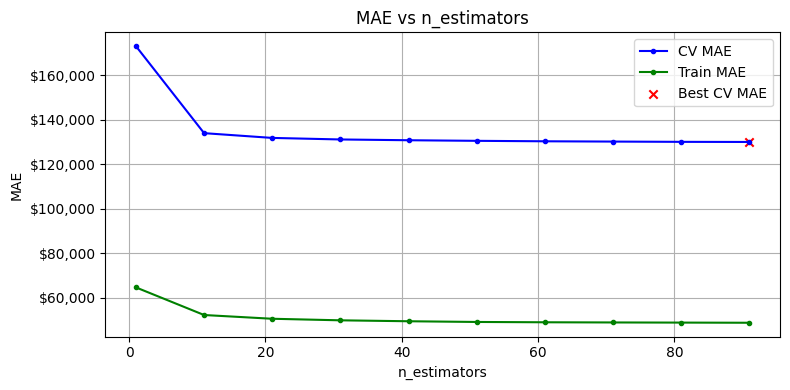

In [ ]:
# Max_features

start = time.time()

parameter_list = range(1,9)                   # <= Make changes here:

param = 'max_features'                        # <= and here

MAEs = []

for n in tqdm(parameter_list):

    MAEs.append( run_bagging_regressor(X_best_features_bagging,y_train,
                                       n_estimators = 790,                  # <= and here
                                       max_samples  = 1.0,
                                       max_features = n
                                      ) )

# Find the minimum value
min_MAE = min(MAEs)

# Find the index of the minimum value
min_index = MAEs.index(min_MAE)

plt.figure(figsize=(6, 4))
plt.title("Bagging Regressor: MAE vs "+param)
plt.plot(parameter_list, MAEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MAE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MAE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MAE {min_MAE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MAE {min_MAE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

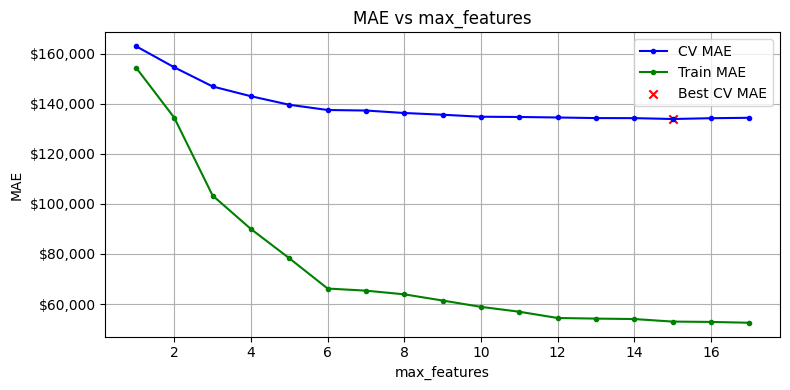

In [ ]:
# Max_samples

start = time.time()

# parameter_list = np.linspace(0.1,1.0,10)       # <= Make changes here:
parameter_list = np.linspace(0.5,1.0,11)

param = 'max_samples'                          # <= and here

MAEs = []

for n in tqdm(parameter_list):

    MAEs.append( run_bagging_regressor(X_best_features_bagging,y_train,
                                       n_estimators = 790,
                                       max_samples  = n,
                                       max_features = 6
                                      ) )

# Find the minimum value
min_MAE = min(MAEs)

# Find the index of the minimum value
min_index = MAEs.index(min_MAE)

plt.figure(figsize=(6, 4))
plt.title("Bagging Regressor: MAE vs "+param)
plt.plot(parameter_list, MAEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MAE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MAE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MAE {min_MAE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MAE {min_MAE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

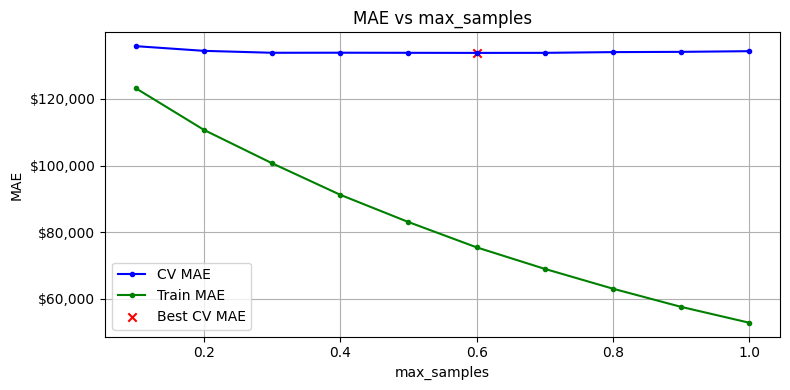

In [ ]:
# Re-do with optimal values

start = time.time()

# parameter_list = range(50,1001,10)
parameter_list = range(100,201)

param = 'n_estimators'

MAEs = []

for n in tqdm(parameter_list):

    MAEs.append( run_bagging_regressor(X_best_features_bagging,y_train,
                                       n_estimators = n,
                                       max_samples  = 1.0,
                                       max_features = 6
                                      ) )

# Find the minimum value
min_MAE = min(MAEs)

# Find the index of the minimum value
min_index = MAEs.index(min_MAE)

plt.figure(figsize=(8, 4))
plt.title("Bagging Regressor: MAE vs "+param)
plt.plot(parameter_list, MAEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MAE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MAE")
plt.xticks(parameter_list)
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MAE {min_MAE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MAE {min_MAE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

In [ ]:
# Random Search
from scipy.stats import randint
n_iterations = 10

param_distributions = {
    'n_estimators'      : randint(540, 581),
    'max_depth'         : randint(1, 16),
    'max_features'      : randint(10,21),
    'min_samples_split' : randint(25,40),
    'min_samples_leaf'  : randint(1,6),
}

# Set up X train and y train
X_train_now = X_best_features_bagging
y_train_now = y_train

# Initialize the BaggingRegressor
model_bagging = BaggingRegressor(random_state=random_state)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator           = model_bagging,
    param_distributions = param_distributions,
    n_iter              = n_iterations,
    cv                  = RepeatedKFold(n_splits=5, n_repeats=10, random_state=random_state),
    random_state        = random_state,
    n_jobs              = -1,
    verbose             = 1,
    scoring             = 'neg_mean_absolute_error')

# Fit the model
random_search.fit(X_train_now, y_train_now)

# Output the best parameters and scores
print("Best parameters:",             random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

In [ ]:
# Bagging Model with Best Hyperparameters

model_bagging = BaggingRegressor(n_estimators=738,
                                max_depth = 4,
                                max_features = 12,
                                min_samples_leaf=1,
                                min_samples_split=2,
                                random_state = random_state)

model_bagging.fit(X_best_features_bagging, y_train)

cv_scores_bagging_4 = -1 * cross_val_score(model_bagging, X_best_features_bagging, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state, ), scoring = 'neg_mean_absolute_error')

print("Bagging Model")
print(f'CV MAE Score Mean: ${cv_scores_bagging_4.mean():,.2f}')
print(f'CV MAE Score StDev: ${cv_scores_bagging_4.std():,.2f}')

**Random Forest (Sweep_Parameters and RandomizedSearchCV)**

In [ ]:
X_best_features_rf = X_transformed_scaled[['avrgziphomevalue', 'calculatedbathnbr', 'propertylandusetypeid', 'buildingqualitytypeid', 'finishedsquarefeet12', 'houseage', 'regionidzip', 'lotsizesquarefeet', 'heatingorsystemtypeid', 'amenitycnt', 'garagetotalsqft', 'roomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'poolcnt', 'taxdelinquencyflag', 'regionidcity', 'fireplacecnt', 'hashottuborspa', 'unitcnt', 'garagecarcnt', 'yearbuilt']]

In [ ]:

def run_random_forest_regressor(X_best_features_rf, y_train,
                                n_estimators = 100,
                                max_depth = None,
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                max_samples = None,
                                max_leaf_nodes=None,
                                max_features = 1.0,
                                bootstrap = True,
                                random_state = random_state,
                                cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state),
                                ccp_alpha=0.0,
                                n_jobs=-1
                               ):

    rf_model = RandomForestRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        max_samples = max_samples,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        max_features = max_features,
        max_leaf_nodes=max_leaf_nodes,
        bootstrap = bootstrap,
        n_jobs = n_jobs,
        random_state = random_state,
        ccp_alpha=ccp_alpha,
    )

    # Perform cross-validation
    neg_mae_scores = cross_val_score(
        rf_model, X_best_features_rf, y_train,
        scoring='neg_mean_absolute_error',
        cv=cv,
        n_jobs=n_jobs
    )

    mean_cv_mae = -np.mean(neg_mae_scores)  # Convert to positive MAE
    return mean_cv_mae

In [ ]:
run_random_forest_regressor(X_best_features_rf, y_train,
                                n_estimators = 100,
                                max_depth = None,
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                max_samples = None,
                                max_leaf_nodes=None,
                                max_features = 1.0,
                                ccp_alpha=0.0,
                               )

np.float64(129795.5408056739)

In [ ]:
from sklearn.metrics         import mean_absolute_error
def run_model(model,
              X_train, y_train,
              n_repeats=5,
              n_jobs=-1,
              **model_params
             ):

    # Instantiate the model if a class is provided
    if isinstance(model, type):
        model = model(**model_params)
    else:
        model.set_params(**model_params)

    # Use negative MAE for cross-validation (since sklearn minimizes loss)
    neg_mae_scores = cross_val_score(
        model,
        X_train, y_train,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=n_jobs
    )

    mean_cv_mae = -np.mean(neg_mae_scores)
    std_cv_mae  =  np.std(neg_mae_scores)

    # Fit the model on the full training set
    model.fit(X_train, y_train)

    # Compute training MAE
    train_preds = model.predict(X_train)
    train_mae   = mean_absolute_error(y_train, train_preds)

    return mean_cv_mae, std_cv_mae, train_mae

In [ ]:
import time

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,              # Defined above
                    y_train          = y_train,
                    verbose          = True,
                    show_mae         = True,
                    show_std         = False,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 5
                   ):


    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary

    cv_maes, std_cvs, train_maes = [], [], []
    no_improve_count = 0
    best_mae = float('inf')

    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        P_temp.pop('MAE_found', None)  # Just in case

        cv_mae, std_cv, train_mae = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_maes.append(cv_mae)
        std_cvs.append(std_cv)
        train_maes.append(train_mae)

        if cv_mae < best_mae - delta:
            best_mae = cv_mae
            no_improve_count = 0
        else:
            no_improve_count += 1

        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break

    # Identify best parameter
    min_cv_mae = min(cv_maes)
    min_index = cv_maes.index(min_cv_mae)
    best_param = parameter_list[min_index]
    Parameters[param] = best_param
    Parameters['MAE_found'] = min_cv_mae

    # ---------- Plotting section ----------
    if verbose:
        partial_param_list = parameter_list[:len(cv_maes)]

        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            x_vals = partial_param_list
            x_labels = partial_param_list

        error_name = 'MAE'

        # Create appropriate number of subplots
        if show_std:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        else:
            fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))

        ax1.set_title(f"{error_name} vs {param}")
        if show_mae:
            ax1.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))

        ax1.plot(x_vals,
                 cv_maes,
                 marker='.', label="CV MAE", color='blue')
        ax1.plot(x_vals,
                 train_maes,
                 marker='.', label="Train MAE", color='green')
        ax1.scatter([x_vals[min_index]],
                    [min_cv_mae],
                    marker='x', label="Best CV MAE", color='red')

        ax1.set_ylabel(error_name)
        ax1.legend()
        ax1.grid()

        # Optional Std Dev Plot
        if show_std:
            ax2.set_title(f"CV Standard Deviation vs {param}")
            ax2.plot(x_vals, std_cvs, marker='.', label="CV MAE Std", color='blue')
            ax2.set_xlabel(param)
            ax2.set_ylabel("Standard Deviation")
            ax2.legend()
            ax2.grid(alpha=0.5)

            if is_boolean:
                ax2.set_xticks(x_vals)
                ax2.set_xticklabels(x_labels)
        else:
            ax1.set_xlabel(param)
            if is_boolean:
                ax1.set_xticks(x_vals)
                ax1.set_xticklabels(x_labels)

        plt.tight_layout()
        plt.show()

        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))

    return Parameters

In [ ]:
# Default parameters for random forest
Default_Parameters_RF = {
    'n_estimators'        : 100,
    'max_depth'           : None,
    'min_samples_split'   : 2,
    'min_samples_leaf'    : 1,
    'max_samples'         : None,
    'max_leaf_nodes'      : None,
    'max_features'        : 1.0,
    'ccp_alpha'           : 0.0,
    'random_state'        : random_state,     # Controls randomness of boosting. Useful for reproducibility.
    'MAE_found'           : float('inf')     # NOT a model parameter, but will record the MAE found for the current parameter choices
}

In [ ]:
Params_RF = Default_Parameters_RF.copy()

In [ ]:
# n_estimators

start = time.time()

param = 'n_estimators'

parameter_list = range(100,400,50)

MAEs = []

for n in tqdm(parameter_list):

    MAEs.append( run_random_forest_regressor(X_best_features_rf, y_train,
                                n_estimators = n,
                                max_depth = None,
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                max_samples = None,
                                max_leaf_nodes=None,
                                max_features = 1.0,
                                ccp_alpha=0.0,
                               ) )



# Find the minimum value
min_MAE = min(MAEs)

# Find the index of the minimum value
min_index = MAEs.index(min_MAE)

plt.figure(figsize=(6, 4))
plt.title("Random Forest Regressor: MAE vs "+param)
plt.plot(parameter_list, MAEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MAE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MAE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MAE {min_MAE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MAE {min_MAE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))


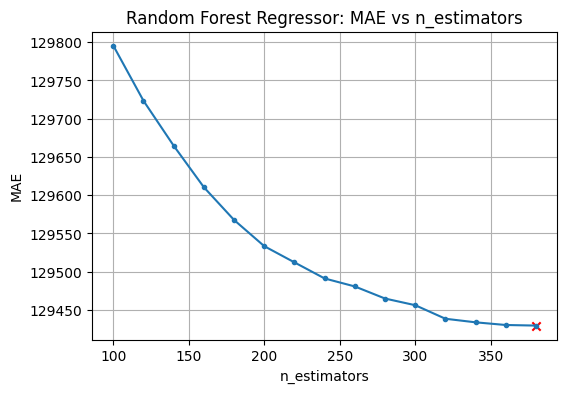

Minimum MAE 129429.5911 found at x = 380

Sweeping (param) ...


Sweeping n_estimators:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping n_estimators:  14%|█▍        | 1/7 [16:20<1:38:01, 980.20s/it]/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping n_estimators:  29%|██▊       | 2/7 [37:58<1:37:16, 1167.28s/it]/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping n_estimators:  43%|████▎     | 3/7 [1:04:50<

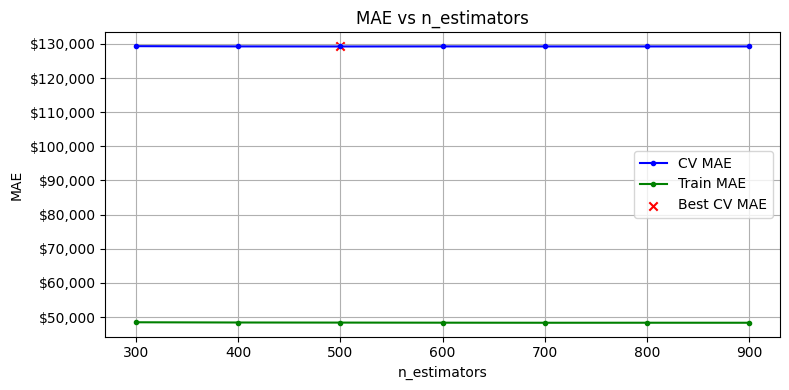

Execution Time: 03:46:46

Parameter n_estimators = 500  MAE = $129,241.33

{'n_estimators': 500, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 1.0, 'ccp_alpha': 0.0, 'random_state': 42, 'MAE_found': np.float64(129241.33382082326)}


In [ ]:
# n_estimators

param = 'n_estimators'
param_list = {param: range(300, 901, 100)}

print(f"Sweeping (param) ...")

Params_RF = sweep_parameter(RandomForestRegressor,
                            Params_RF,
                            param,
                            param_list[param],
                            X_train = X_best_features_rf,
                            n_jobs = -1,
                            n_repeats = 5
                            )

print(f"\nParameter {param} = {Params_RF[param]}  MAE = ${Params_RF['MAE_found']:,.2f}\n")
print(Params_RF)

In [ ]:
# max_depth

# record beginning time
start = time.time()

param = 'max_depth'

parameter_list = range(3,16)             # be sure to compare this with the default None

MAEs = []

for md in tqdm(parameter_list):

    MAEs.append( run_random_forest_regressor(X_best_features_rf, y_train,
                                n_estimators = 380,
                                max_depth = md,
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                max_samples = None,
                                max_leaf_nodes=None,
                                max_features = 1.0,
                                ccp_alpha=0.0,
                               ) )


# Find the minimum value
min_MAE = min(MAEs)

# Find the index of the minimum value
min_index = MAEs.index(min_MAE)

plt.figure(figsize=(6, 4))
plt.title("Random Forest Regressor: MAE vs "+param)
plt.plot(parameter_list, MAEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MAE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MAE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MAE {min_MAE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MAE {min_MAE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

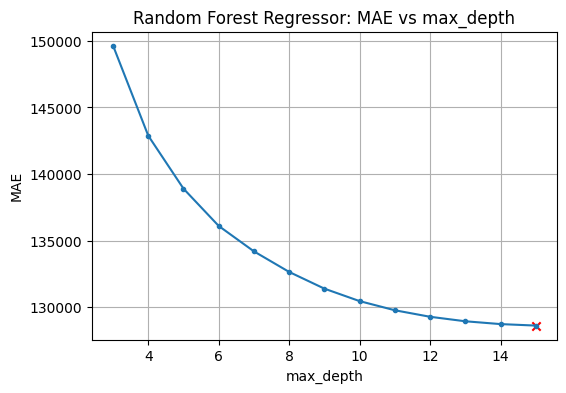

Minimum MAE 128612.2512 found at x = 15

Sweeping (param) ...


Sweeping min_samples_split:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping min_samples_split:  20%|██        | 1/5 [27:42<1:50:48, 1662.15s/it]/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping min_samples_split:  40%|████      | 2/5 [51:44<1:16:38, 1532.90s/it]/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping min_samples_split: 100%|████

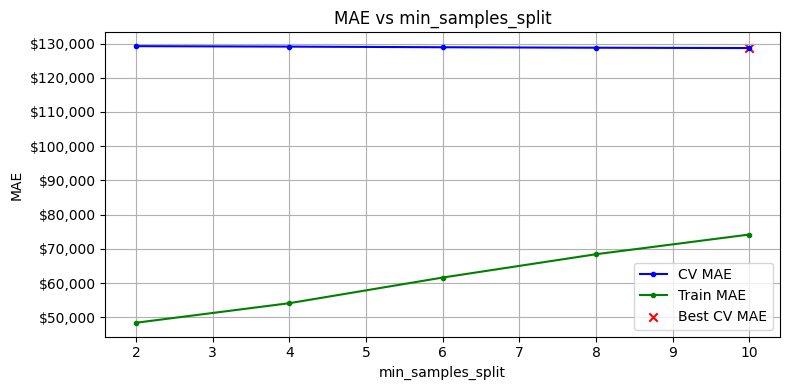

Execution Time: 01:57:10

Parameter min_samples_split = 10  MAE = $128,685.11

{'n_estimators': 500, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 1.0, 'ccp_alpha': 0.0, 'random_state': 42, 'MAE_found': np.float64(128685.10683386792)}


In [ ]:
# min_samples_split

param = 'min_samples_split'
param_list = {param: range(2,11,2) }

print(f"Sweeping (param) ...")

Params_RF = sweep_parameter(RandomForestRegressor,
                            Params_RF,
                            param,
                            param_list[param],
                            X_train = X_best_features_rf,
                            n_jobs = -1,
                            n_repeats = 5
                            )

print(f"\nParameter {param} = {Params_RF[param]}  MAE = ${Params_RF['MAE_found']:,.2f}\n")
print(Params_RF)


Sweeping (param) ...


Sweeping max_features: 100%|██████████| 6/6 [1:07:42<00:00, 677.10s/it]


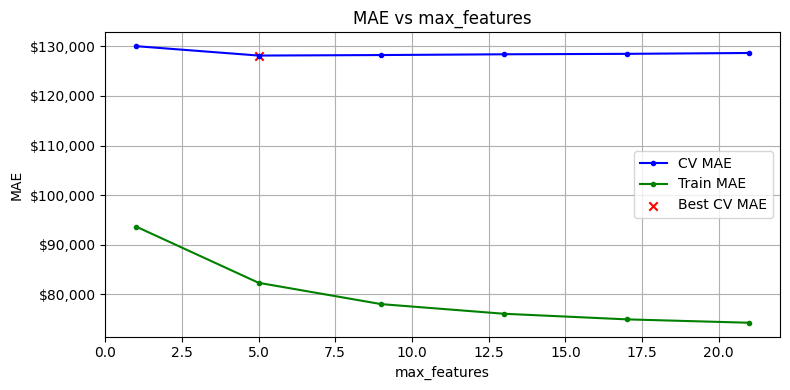

Execution Time: 01:07:42

Parameter max_features = 5  MAE = $128,144.92

{'n_estimators': 500, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 5, 'ccp_alpha': 0.0, 'random_state': 42, 'MAE_found': np.float64(128144.92150313321)}


In [ ]:
# max_features

param = 'max_features'
param_list = {param: range(1,23,4)}

print(f"Sweeping (param) ...")

Params_RF = sweep_parameter(RandomForestRegressor,
                            Params_RF,
                            param,
                            param_list[param],
                            X_train = X_best_features_rf,
                            n_jobs = -1,
                            n_repeats = 5
                            )

print(f"\nParameter {param} = {Params_RF[param]}  MAE = ${Params_RF['MAE_found']:,.2f}\n")
print(Params_RF)


Sweeping (param) ...


Sweeping min_samples_leaf: 100%|██████████| 3/3 [16:29<00:00, 329.84s/it]


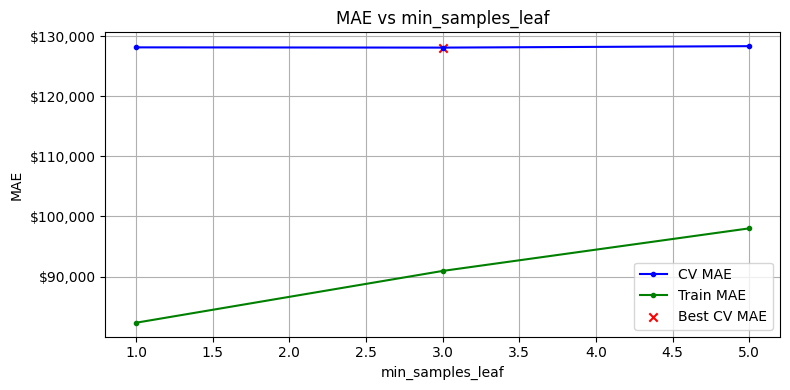

Execution Time: 00:16:29

Parameter min_samples_leaf = 3  MAE = $128,104.46

{'n_estimators': 500, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 5, 'ccp_alpha': 0.0, 'random_state': 42, 'MAE_found': np.float64(128104.45673090359)}


In [ ]:
# min_samples_leaf

param = 'min_samples_leaf'
param_list = {param: range(1,6,2)}

print(f"Sweeping (param) ...")

Params_RF = sweep_parameter(RandomForestRegressor,
                            Params_RF,
                            param,
                            param_list[param],
                            X_train = X_best_features_rf,
                            n_jobs = -1,
                            n_repeats = 5
                            )

print(f"\nParameter {param} = {Params_RF[param]}  MAE = ${Params_RF['MAE_found']:,.2f}\n")
print(Params_RF)

In [ ]:
# Random Search
from scipy.stats import randint
n_iterations = 10

param_distributions = {
    'n_estimators'      : randint(450, 551),
    'max_depth'         : randint(12, 20),
    'max_features'      : randint(3,13),
    'min_samples_split' : randint(8,16),
    'min_samples_leaf'  : randint(2,5),
}

# Set up X train and y train
X_train_now = X_best_features_rf
y_train_now = y_train

# Initialize the RandomForestRegressor
model_rf = RandomForestRegressor(random_state=random_state)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator           = model_rf,
    param_distributions = param_distributions,
    n_iter              = n_iterations,
    cv                  = 5,
    random_state        = random_state,
    n_jobs              = -1,
    verbose             = 1,
    scoring             = 'neg_mean_absolute_error')

# Fit the model
random_search.fit(X_train_now, y_train_now)

# Output the best parameters and scores
print("Best parameters:",             random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'max_depth': 18, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 473}
Best cross-validation score: -128124.10544540038


In [ ]:
# Random Forest Model with Best Hyperparameters

model_rf = RandomForestRegressor(n_estimators=473,
                                max_depth = 18,
                                max_features = 10,
                                min_samples_leaf=2,
                                min_samples_split=11,
                                random_state = random_state)

model_rf.fit(X_best_features_rf, y_train)

cv_scores_rf_4 = -1 * cross_val_score(model_rf, X_best_features_rf, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state, ), scoring = 'neg_mean_absolute_error')

print("Random Forest Model")
print(f'CV MAE Score Mean: ${cv_scores_rf_4.mean():,.2f}')
print(f'CV MAE Score StDev: ${cv_scores_rf_4.std():,.2f}')

Random Forest Model
CV MAE Score Mean: $128,152.91
CV MAE Score StDev: $778.48


### Part 4: Discussion [3 pts]

Reflect on your tuning process and final results:

- What was your tuning strategy for each model? Why did you choose those hyperparameters?
- Did you find that certain types of preprocessing or feature engineering worked better with specific models?


For the models, we first used sweep parameters and then RandomizedSearchCV. The sweep parameters was helpful to identify a range of values to use for each parameter in the RandomizedSearchCV.

### Part 5: Final Model and Design Reassessment [6 pts]

In this part, you will finalize your best-performing model.  You’ll also consolidate and present the key code used to run your model on the preprocessed dataset.
**Requirements:**

- Decide one your final model among the three contestants.

- Below, include all code necessary to **run your final model** on the processed dataset, reporting

    - Mean and standard deviation of CV MAE Score.
    
    - Test score on held-out test set.




**Final Model - Random Forest Model**

In [ ]:
 random_state = 42

 # Import dataset and create train/test

df = pd.read_csv("zillow_cleaned.csv")
df = df.dropna()

X = df.drop(columns=["taxvaluedollarcnt"])
y = df["taxvaluedollarcnt"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [ ]:
# Transform and scale features (X train)

X_transformed = X_train.copy()

# Transformation 1: House age
X_transformed['houseage'] = X_transformed["assessmentyear"] - X_transformed["yearbuilt"]

# Transformation 2a: average zip home value
# Step 1: Compute average home value by zip (on full data)
zip_avgs = df.groupby("regionidzip")["taxvaluedollarcnt"].mean()

# Step 2: Map to X_transformed (training set only)
X_transformed["avrgziphomevalue"] = X_transformed["regionidzip"].map(zip_avgs)

# Transformation 3: amenity count
X_transformed["amenitycnt"] = X_transformed["poolcnt"] + X_transformed["fireplacecnt"] + X_transformed["garagecarcnt"] + X_transformed["hashottuborspa"]

# Scale Features
X_transformed_scaled = pd.DataFrame(
    scaler.fit_transform(X_transformed),
    columns=X_transformed.columns,
    index=X_transformed.index)

In [ ]:
 # Create final X dataset

 # X_train_final = X_best_features_rf

 X_train_final = X_transformed_scaled[['avrgziphomevalue', 'calculatedbathnbr', 'propertylandusetypeid', 'buildingqualitytypeid', 'finishedsquarefeet12', 'houseage', 'regionidzip', 'lotsizesquarefeet', 'heatingorsystemtypeid', 'amenitycnt', 'garagetotalsqft', 'roomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'poolcnt', 'taxdelinquencyflag', 'regionidcity', 'fireplacecnt', 'hashottuborspa', 'unitcnt', 'garagecarcnt', 'yearbuilt']]

In [ ]:
# Final model with cross-validation

final_model = RandomForestRegressor(n_estimators=473,
                                max_depth = 18,
                                max_features = 10,
                                min_samples_leaf=2,
                                min_samples_split=11,
                                random_state = random_state)

final_model.fit(X_train_final, y_train)

cv_scores_final = -1 * cross_val_score(final_model, X_train_final, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state, ), scoring = 'neg_mean_absolute_error')

print("Final Model - Random Forest")
print(f'CV MAE Score Mean: ${cv_scores_final.mean():,.2f}')
print(f'CV MAE Score StDev: ${cv_scores_final.std():,.2f}')


Final Model - Random Forest
CV MAE Score Mean: $128,913.93
CV MAE Score StDev: $1,694.00


In [ ]:
# Transform and scale (X test)

X_test_final = X_test.copy()

# Transformation 1: House age
X_test_final['houseage'] = X_test_final["assessmentyear"] - X_test_final["yearbuilt"]

# Transformation 2a: average zip home value
# Step 1: Compute average home value by zip (on full data)
zip_avgs = df.groupby("regionidzip")["taxvaluedollarcnt"].mean()

# Step 2: Map to X_transformed (training set only)
X_test_final["avrgziphomevalue"] = X_test_final["regionidzip"].map(zip_avgs)

# Transformation 3: amenity count
X_test_final["amenitycnt"] = X_test_final["poolcnt"] + X_test_final["fireplacecnt"] + X_test_final["garagecarcnt"] + X_test_final["hashottuborspa"]

# Scale Features
X_test_final_scaled = pd.DataFrame(
    scaler.fit_transform(X_test_final),
    columns=X_test_final.columns,
    index=X_test_final.index)

NameError: name 'X_test' is not defined

In [ ]:
# MAE score on held-out test set

y_pred = final_model.predict(X_test_final_scaled)

test_mae = mean_absolute_error(y_test, y_pred)

print(f'Test MAE: ${test_mae:,.2f}')


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- assessmentyear
- bathroomcnt
- fullbathcnt
- regionidcounty


### Part 5: Discussion [8 pts]

In this final step, your goal is to synthesize your entire modeling process and assess how your earlier decisions influenced the outcome. Please address the following:

1. Model Selection:
- Clearly state which model you selected as your final model and why.

- What metrics or observations led you to this decision?

- Were there trade-offs (e.g., interpretability vs. performance) that influenced your choice?

2. Revisiting an Early Decision

- Identify one specific preprocessing or feature engineering decision from Milestone 1 (e.g., how you handled missing values, how you scaled or encoded a variable, or whether you created interaction or polynomial terms).

- Explain the rationale for that decision at the time: What were you hoping it would achieve?

- Now that you've seen the full modeling pipeline and final results, reflect on whether this step helped or hindered performance. Did you keep it, modify it, or remove it?

- Justify your final decision with evidence—such as validation scores, visualizations, or model diagnostics.

3. Lessons Learned

- What insights did you gain about your dataset or your modeling process through this end-to-end workflow?

- If you had more time or data, what would you explore next?

After comparing our three models, Gradient Boosting Trees, Bagging, and Random Forest, we have decided that the best model is the Random Forest Model with the following parameters:'n_estimators': 473, 'max_depth': 18, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 11. We used the best features selected from the pre-processed dataset during forward selection, which includes the three new features that we engineered: house age, average home price per zip code, and amenities count. This model has the lowest CV MAE score throughout the modeling process.

One feature engineering decision that we made in Milestone One was to apply a log transformation to the target variable. However, we decided early on in Milestone Two to only use the original target variable as the log scale made it difficult to interpret and compare metrics against the model ran without the feature engineering.  

Another feature engineering decision that we made at the start was to create a feature called home price deviation. We decided to remove this new feature too because we realized it was contributing to significant overfitting in the models.

Through this end-to-end workflow, we have learned